<a href="https://colab.research.google.com/github/Aryathama/testtesttest.github.io/blob/main/VRP_SC_ATM_BCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initial Code**

In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns
import random
from copy import deepcopy
import matplotlib.cm as cm
import numpy as np

In [ ]:
# Load data
df = pd.read_excel('Dataset VRP ATM BCA.xlsx')

In [ ]:
# Konversi Longitude dan Latitude ke desimal derajat (jika perlu dibagi 1e6)
df['Longitude'] = df['Longitude'] / 1e6
df['Latitude'] = df['Latitude'] / 1e6

# Ambil fitur lokasi
locations = df[['Longitude', 'Latitude']]

# Standarisasi data
scaler = StandardScaler()
locations_scaled = scaler.fit_transform(locations)

In [ ]:
# Inisialisasi kolom 'demand' dari file Excel
df['Demand'] = df['Demand']  # Pastikan kolom ini memang ada di file Excel

# Inisialisasi kapasitas kendaraan (misalnya 100 per kendaraan)
vehicle_capacity = 80

In [ ]:
from math import radians, sin, cos, sqrt, atan2
import numpy as np

def haversine(coord1, coord2):
    R = 6371.0  # radius bumi dalam kilometer
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Ambil array koordinat (lon, lat)
coordinates = df[['Longitude', 'Latitude']].values
n = len(coordinates)

# Buat distance matrix berdasarkan Haversine
distance_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i != j:
            distance_matrix[i][j] = haversine(coordinates[i], coordinates[j])

In [ ]:
def plot_routes(df, routes, depot_id=0, title=None): # Tambahkan depot_id sebagai argumen
    plt.figure(figsize=(10, 8))
    colors = cm.get_cmap('tab20', len(routes))

    # Plot semua rute
    for i, route in enumerate(routes):
        # Tambahkan depot ke awal dan akhir setiap rute untuk plotting
        full_route_for_plotting = [depot_id] + route + [depot_id]

        lats = [df.loc[idx, 'Latitude'] for idx in full_route_for_plotting]
        longs = [df.loc[idx, 'Longitude'] for idx in full_route_for_plotting]

        plt.plot(longs, lats, marker='o', label=f'Rute {i+1}', color=colors(i))

        # Tampilkan index titik pelanggan (tidak depot)
        for j, idx in enumerate(route): # Iterasi hanya pelanggan, bukan full_route_for_plotting
            plt.text(df.loc[idx, 'Longitude'], df.loc[idx, 'Latitude'], str(idx), fontsize=8, ha='center', va='bottom')

    # Tandai depot secara eksplisit dengan label 'D'
    depot_coords = df.loc[depot_id]
    plt.scatter(depot_coords['Longitude'], depot_coords['Latitude'], c='red', s=150, label='Depot', edgecolors='black', zorder=5)
    plt.text(depot_coords['Longitude'], depot_coords['Latitude'], 'D', fontsize=10, color='white', ha='center', va='center', weight='bold')


    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Hitung total jarak semua rute (include depot)
def calculate_total_distance(routes, dist_matrix, depot):
    total = 0
    for route in routes:
        prev = depot
        for customer in route:
            total += dist_matrix[prev][customer]
            prev = customer
        total += dist_matrix[prev][depot]  # kembali ke depot
    return total

In [ ]:
depot_id = 0

In [ ]:
demands_processed = df.set_index('id')['Demand'].to_dict()
coordinates_processed = df.set_index('id')[['Longitude', 'Latitude']].apply(tuple, axis=1).to_dict()

In [ ]:
def create_distance_matrix(coords): # Ini harusnya sudah ada
    all_ids = list(coords.keys())
    if not all_ids:
        return np.array([[]]) # Handle empty case

    max_node_id = max(all_ids)
    # min_node_id = min(all_ids) # Ini tidak terlalu relevan untuk ukuran matriks

    # Ukuran matriks harus mengakomodasi ID terbesar + 1 (untuk indeks 0)
    n = max_node_id + 1

    dist = np.zeros((n, n))

    if coords:
        # Perhatikan: max(coords.keys()) akan bekerja untuk dictionary
        max_node_id = max(coords.keys()) if coords else 0
    n = max_node_id + 1 # Ukuran matrix sesuai dengan ID terbesar
    dist = np.zeros((n, n))
    for i in coords:
        for j in coords:
            if i < n and j < n: # Pastikan indeks ada dalam bounds matriks
                dist[i][j] = haversine(coords[i], coords[j])
            else:
                # Handle jika ada ID pelanggan yang lebih besar dari n-1
                # atau tidak ada di dictionary coords
                pass
    return dist

distance_matrix_processed = create_distance_matrix(coordinates_processed)

In [ ]:
if depot_id not in coordinates_processed:
    print(f"Depot ID {depot_id} not found in coordinates. Assuming depot is customer with id 0.")
    # Cari koordinat depot dari df, asumsikan baris pertama adalah depot jika id 0 tidak ada
    # atau cari baris yang id-nya 0 di df
    depot_row = df[df['id'] == depot_id]
    if not depot_row.empty:
        depot_lon = depot_row['Longitude'].iloc[0]
        depot_lat = depot_row['Latitude'].iloc[0]
    else:
        # Fallback: jika depot_id=0 tidak ada di kolom 'id' dan tidak ada baris 0
        # ini mungkin terjadi jika id dimulai dari 1
        # Ambil saja dari baris pertama df (misal asumsi baris 0 adalah depot)
        print(f"Warning: Depot ID {depot_id} not explicitly in 'id' column. Using df.loc[0] as depot.")
        depot_lon = df.loc[0, 'Longitude']
        depot_lat = df.loc[0, 'Latitude']

    coordinates_processed[depot_id] = (depot_lon, depot_lat)
    demands_processed[depot_id] = 0 # Permintaan depot adalah 0
    print(f"Added Depot {depot_id} to processed data: {coordinates_processed[depot_id]}")

# Panggil fungsi create_distance_matrix_from_dict setelah semua data 'processed' siap
distance_matrix = create_distance_matrix(coordinates_processed)

print(f"Shape of distance_matrix after creation: {distance_matrix.shape}")
print(f"Max ID used in coordinates_processed: {max(coordinates_processed.keys())}")
print(f"Depot ID (final check): {depot_id}")

Shape of distance_matrix after creation: (51, 51)
Max ID used in coordinates_processed: 50
Depot ID (final check): 0


In [ ]:
pip install folium requests polyline

In [ ]:
import folium
import requests
import json
import matplotlib
import matplotlib.pyplot as plt # Tetap diperlukan jika Anda masih ingin plot Matplotlib
import numpy as np # Untuk np.argmin

OSRM_BASE_URL = "http://router.project-osrm.org/route/v1/driving/"

def get_osrm_route(coords_list):
    """
    Mengambil rute dari OSRM API.
    Args:
        coords_list (list): List tuple (latitude, longitude) dari titik-titik.
    Returns:
        list: List tuple (latitude, longitude) dari jalur rute, atau None jika gagal.
    """
    if not coords_list or len(coords_list) < 2:
        return None

    # OSRM expects coordinates in 'longitude,latitude' format
    # coords_list sekarang seharusnya memiliki format (latitude, longitude)
    coords_str_parts = []
    # --- DEBUG: Print individual coordinate formatting ---
    for k, (lat, lon) in enumerate(coords_list):
        formatted_coord = f"{lon},{lat}" # Ini yang seharusnya dikirim ke OSRM
        coords_str_parts.append(formatted_coord)
        # if k < 5: # Print hanya 5 koordinat pertama untuk debug
        #     print(f"  DEBUG OSRM Segmen Coord {k}: (Lat: {lat}, Lon: {lon}) -> Formatted: '{formatted_coord}'")
        # elif k == 5:
        #     print("  ...")
    coords_str = ";".join(coords_str_parts)
    # --- END DEBUG ---

    url = f"{OSRM_BASE_URL}{coords_str}?geometries=geojson&overview=full"

    # --- DEBUG: Print URL yang terbentuk ---
    # print(f"DEBUG OSRM Request URL (Full): {url}")
    # --- END DEBUG ---

    try:
        response = requests.get(url)
        response.raise_for_status()  # Angkat HTTPError untuk status kode yang buruk (4xx atau 5xx)
        data = response.json()

        if data['code'] == 'Ok':
            # rute geometry dari OSRM adalah list of [longitude, latitude]
            route_geometry = data['routes'][0]['geometry']['coordinates']
            # Konversi kembali ke list of (latitude, longitude) untuk Folium
            return [(lat, lon) for lon, lat in route_geometry]
        else:
            print(f"Error OSRM response code: {data.get('code')}, message: {data.get('message')}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error requesting OSRM route: {e}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error decoding OSRM response: {e}")
        return None

# ===== Fungsi plot_routes_folium yang Telah Dimodifikasi (plot_routes_folium_v2) =====
def plot_routes_folium_v2(df, routes, title="VRP Routes (OSRM Powered)"):
    if df.empty:
        print("DataFrame kosong. Tidak dapat memplot rute.")
        return None

    # !!! PERBAIKAN PENTING DI SINI !!!
    # Memastikan coordinates_dict menyimpan (latitude, longitude) yang BENAR
    # Berdasarkan debug output, row['Latitude'] berisi Longitude dan row['Longitude'] berisi Latitude.
    coordinates_dict = {idx: (row['Longitude'], row['Latitude']) for idx, row in df.iterrows()}
    # === AKHIR PERBAIKAN ===

    depot_id = 0 # Asumsi depot selalu di index 0

    if not coordinates_dict:
        print("Koordinat tidak tersedia untuk plotting.")
        return None

    depot_lat, depot_lon = coordinates_dict[depot_id]
    m = folium.Map(location=[depot_lat, depot_lon], zoom_start=12)

    # Tambahkan marker untuk depot
    folium.Marker(
        location=[depot_lat, depot_lon],
        icon=folium.Icon(color='red', icon='warehouse', prefix='fa'),
        tooltip=f"Depot {depot_id}"
    ).add_to(m)

    # Tambahkan marker untuk pelanggan (ATM)
    for node_id, (lat, lon) in coordinates_dict.items():
        if node_id != depot_id:
            folium.Marker(
                location=[lat, lon],
                icon=folium.Icon(color='blue', icon='truck', prefix='fa'), # Contoh icon
                tooltip=f"ATM {node_id}"
            ).add_to(m)

    # Menentukan warna untuk rute
    # Perbaikan MatplotlibDeprecationWarning
    cmap = plt.colormaps.get_cmap('hsv') # <--- UBAH BARIS INI
    folium_colors = [matplotlib.colors.to_hex(cmap(i / len(routes))) for i in range(len(routes))] # Pastikan normalisasi warna

    all_coordinates_for_bounds = [] # Untuk menyesuaikan batas peta

    # Batas maksimum waypoint untuk OSRM demo server (gunakan 99 untuk aman)
    max_osrm_points_per_request = 99

    for i, route_customer_indices in enumerate(routes):
        full_route_ids = [depot_id] + route_customer_indices + [depot_id]

        # --- Tambahan: Hapus titik duplikat yang berurutan ---
        deduplicated_route_ids = []
        if full_route_ids:
            deduplicated_route_ids.append(full_route_ids[0])
            for k in range(1, len(full_route_ids)):
                if full_route_ids[k] != full_route_ids[k-1]:
                    deduplicated_route_ids.append(full_route_ids[k])

        if len(deduplicated_route_ids) < 2:
            print(f"Rute {i+1} (setelah deduplikasi) terlalu pendek ({len(deduplicated_route_ids)} titik), dilewati.")
            continue

        route_coords_lat_lon = [coordinates_dict[node_id] for node_id in deduplicated_route_ids]

        combined_osrm_path = []
        current_route_color = folium_colors[i]

        for j in range(0, len(route_coords_lat_lon), max_osrm_points_per_request -1):
            segment_coords = route_coords_lat_lon[j : j + max_osrm_points_per_request]

            if len(segment_coords) < 2:
                continue

            osrm_segment_path = get_osrm_route(segment_coords)

            if osrm_segment_path:
                if combined_osrm_path and osrm_segment_path and combined_osrm_path[-1] == osrm_segment_path[0]:
                    combined_osrm_path.extend(osrm_segment_path[1:])
                else:
                    combined_osrm_path.extend(osrm_segment_path)
            else:
                print(f"Warning: Gagal mendapatkan rute OSRM untuk segmen Route {i+1} dari index {j}. Memplot garis lurus untuk segmen ini.")
                straight_line_segment_coords = segment_coords
                folium.PolyLine(
                    locations=straight_line_segment_coords,
                    color=current_route_color,
                    weight=2,
                    opacity=0.5,
                    dash_array='5, 5',
                    tooltip=f"Route {i+1} Segmen (Straight Line Fallback)"
                ).add_to(m)
                all_coordinates_for_bounds.extend(straight_line_segment_coords)


        if combined_osrm_path:
            folium.PolyLine(
                locations=combined_osrm_path,
                color=current_route_color,
                weight=4,
                opacity=0.7,
                tooltip=f"Route {i+1}"
            ).add_to(m)
            all_coordinates_for_bounds.extend(combined_osrm_path)
        elif not combined_osrm_path and len(deduplicated_route_ids) > 1:
            print(f"Warning: Seluruh rute {i+1} gagal mendapatkan rute OSRM. Memplot garis lurus untuk rute keseluruhan.")
            straight_line_coords = route_coords_lat_lon
            folium.PolyLine(
                locations=straight_line_coords,
                color=current_route_color,
                weight=2,
                opacity=0.5,
                dash_array='5, 5',
                tooltip=f"Route {i+1} (Straight Line Fallback)"
            ).add_to(m)
            all_coordinates_for_bounds.extend(straight_line_coords)


    title_html = f'<h3 align="center" style="font-size:20px"><b>{title}</b></h3>'
    m.get_root().html.add_child(folium.Element(title_html))

    if all_coordinates_for_bounds:
        min_lat = min(c[0] for c in all_coordinates_for_bounds)
        max_lat = max(c[0] for c in all_coordinates_for_bounds)
        min_lon = min(c[1] for c in all_coordinates_for_bounds)
        max_lon = max(c[1] for c in all_coordinates_for_bounds)
        m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
    else:
        m.fit_zoom(zoom_start=12)

    return m

# **Implementasi GA (Radit)**

## Algoritma

In [ ]:
# Fungsi decode kromosom → jadi list rute (dengan constraint kapasitas)
def split_routes(chromosome, demands, capacity):
    routes = []
    route = []
    load = 0
    for customer in chromosome:
        demand = demands[customer]
        if load + demand <= capacity:
            route.append(customer)
            load += demand
        else:
            routes.append(route)
            route = [customer]
            load = demand
    if route:
        routes.append(route)
    return routes

In [ ]:
# Generate kromosom acak
def generate_chromosome(customers):
    chromosome = customers[:]
    random.shuffle(chromosome)
    return chromosome

In [ ]:
def generate_nearest_neighbor_chromosome(customer_ids, dist_matrix, depot_id):
    if not customer_ids:
        return []

    unvisited = set(customer_ids)
    chromosome = []
    current = depot_id

    while unvisited:
        # Cari customer terdekat
        nearest_customer, min_distance = None, float('inf')

        for customer in unvisited:
            try:
                distance = dist_matrix[current, customer]
            except IndexError:
                print(f"Warning: Invalid index [{current}, {customer}] in distance matrix.")
                continue

            if distance < min_distance:
                min_distance = distance
                nearest_customer = customer

        if nearest_customer is not None:
            chromosome.append(nearest_customer)
            unvisited.remove(nearest_customer)
            current = nearest_customer
        else:
            print("Warning: Nearest Neighbor stuck, adding remaining customers randomly.")
            chromosome.extend(unvisited)
            break

    return chromosome

In [ ]:
def order_crossover(p1, p2):
    size = len(p1)
    if size == 0:
        return []

    child = [None] * size

    # Pilih dua titik potong
    start, end = sorted(random.sample(range(size), 2))

    # Salin segmen dari Parent 1 ke anak
    child[start:end+1] = p1[start:end+1]

    p2_remaining_genes_ordered = [gene for gene in p2 if gene not in child[start:end+1]]

    p2_ptr = 0
    for i in range(size):
        if start <= i <= end:
            continue

        if p2_ptr < len(p2_remaining_genes_ordered):
            child[i] = p2_remaining_genes_ordered[p2_ptr]
            p2_ptr += 1
        else:
            remaining_from_p1 = [gene for gene in p1 if gene not in child]
            if remaining_from_p1:
                child[i] = remaining_from_p1.pop(0)

    return child

In [ ]:
def mutate(chromosome, mutation_rate):
    if random.random() < mutation_rate and len(chromosome) >= 2:
        idx1, idx2 = sorted(random.sample(range(len(chromosome)), 2))
        chromosome[idx1:idx2+1] = chromosome[idx1:idx2+1][::-1]
    return chromosome

In [ ]:
# Tournament Selection
def tournament_selection(pop, scores, k=3):
    selected = random.sample(list(zip(pop, scores)), k)
    selected.sort(key=lambda x: x[1])
    return deepcopy(selected[0][0])

In [ ]:
# Evaluate fitness awal
def evaluate_population(pop, demands, capacity, dist_matrix, depot_id):
    fitness = []
    for chrom in pop:
        routes = split_routes(chrom, demands, capacity)
        total_dist = calculate_total_distance(routes, distance_matrix, depot_id)
        fitness.append(total_dist)
    return fitness

In [ ]:
def calculate_route_distance(route, dist_matrix, depot):
    distance = dist_matrix[depot][route[0]]
    for i in range(len(route) - 1):
        distance += dist_matrix[route[i]][route[i + 1]]
    distance += dist_matrix[route[-1]][depot]
    return distance

In [ ]:
def two_opt(route, dist_matrix, depot):
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(best) - 2):
            for j in range(i + 1, len(best)):
                if j - i == 1:
                    continue
                new_route = best[:i] + best[i:j][::-1] + best[j:]
                if calculate_route_distance(new_route, dist_matrix, depot) < calculate_route_distance(best, dist_matrix, depot):
                    best = new_route
                    improved = True
    return best

In [ ]:
def two_opt_all_routes(routes, dist_matrix, depot):
    return [two_opt(route, dist_matrix, depot) if len(route) > 3 else route for route in routes]

In [ ]:
def enhanced_ga_2opt(pop_size, num_generations, mutation_rate,
                                   initialization_heuristic_ratio,
                                   capacity, demands, coordinates, depot_id):

    customer_ids = [cid for cid in coordinates_processed.keys() if cid != depot_id]

    population = []
    best_solution = None
    best_score = float('inf')
    history = []
    time_history = []

    start_time = time.time()

    dist_matrix = distance_matrix

    num_heuristic_individuals = int(pop_size * initialization_heuristic_ratio)

    for _ in range(num_heuristic_individuals):
        nn_chromosome = generate_nearest_neighbor_chromosome(customer_ids, dist_matrix, depot_id)
        if nn_chromosome:
            population.append(nn_chromosome)
        else:
            population.append(generate_chromosome(customer_ids))

    while len(population) < pop_size:
        population.append(generate_chromosome(customer_ids))

    population = population[:pop_size]

    for gen in range(num_generations):
        scores = evaluate_population(population, demands, capacity, dist_matrix, depot_id)
        new_population = []

        elite_count = max(1, int(pop_size * 0.05))
        elite_pairs = sorted(zip(population, scores), key=lambda x: x[1])[:elite_count]
        elites = [deepcopy(ind) for ind, _ in elite_pairs]
        new_population.extend(elites)

        while len(new_population) < pop_size:
            p1 = tournament_selection(population, scores, k=3)
            p2 = tournament_selection(population, scores, k=3)

            if p1 is None or p2 is None or not customer_ids:
                new_population.append(generate_chromosome(customer_ids))
                if len(new_population) >= pop_size: break
                continue

            child = order_crossover(p1, p2)

            if not child: child = deepcopy(p1)
            child = mutate(child, mutation_rate)

            routes_before_2opt = split_routes(child, demands, capacity)
            routes_after_2opt = two_opt_all_routes(routes_before_2opt, dist_matrix, depot_id)
            child_after_2opt = [cust for route in routes_after_2opt for cust in route]

            if child_after_2opt:
                new_population.append(child_after_2opt)
            else:
                new_population.append(generate_chromosome(customer_ids))

            if len(new_population) >= pop_size:
                break

        population = new_population[:pop_size]
        current_scores = evaluate_population(population, demands, capacity, dist_matrix, depot_id)

        gen_best_idx = np.argmin(current_scores)
        gen_best_score = current_scores[gen_best_idx]
        if gen_best_score < best_score:
            best_score = gen_best_score
            best_solution = deepcopy(population[gen_best_idx])

        history.append(best_score)
        time_history.append(time.time() - start_time)

    return {
        "best_solution": best_solution,
        "best_distance": best_score,
        "history": history,
        "time": time_history
    }

## Hasil

In [ ]:
# --- Eksekusi GA + 2-Opt dengan Inisialisasi yang Ditingkatkan ---
# Gunakan parameter terbaik dari tuning sebelumnya, dan tambahkan rasio heuristik
POP_SIZE_ENHANCED = 150
NUM_GENERATIONS_ENHANCED = 200
MUTATION_RATE_ENHANCED = 0.25
INITIALIZATION_HEURISTIC_RATIO = 0.1 # Mulai dengan 10% heuristik, bisa ditingkatkan

print("\n--- Menjalankan Enhanced GA + 2-Opt ---")
result_ga = enhanced_ga_2opt(
                pop_size=POP_SIZE_ENHANCED,
                num_generations=NUM_GENERATIONS_ENHANCED,
                mutation_rate=MUTATION_RATE_ENHANCED,
                initialization_heuristic_ratio=INITIALIZATION_HEURISTIC_RATIO,
                capacity=vehicle_capacity,
                demands=demands_processed, # GUNAKAN demands_processed (dictionary)
                coordinates=coordinates_processed, # GUNAKAN coordinates_processed (dictionary)
                depot_id=depot_id
            )


--- Menjalankan Enhanced GA + 2-Opt ---


In [ ]:
if result_ga['best_solution']:
    print(f"Best Total Distance: {result_ga['best_distance']:.2f}")

    best_routes_ga_for_display = split_routes(
        result_ga['best_solution'],
        demands_processed,
        vehicle_capacity
    )

    print("\nBest Routes (Enhanced GA + 2-Opt):")
    total_customers_in_routes = 0
    for i, route in enumerate(best_routes_ga_for_display):
        route_display = [depot_id] + route + [depot_id]
        route_cost = calculate_route_distance([depot_id] + route + [depot_id], distance_matrix, depot_id)

        # Hitung beban rute
        route_load = sum(demands_processed.get(c, 0) for c in route)

        print(f"  Route {i+1}: {route_display} (Cost: {route_cost:.2f}, Load: {route_load}/{vehicle_capacity})")
        total_customers_in_routes += len(route)

    print(f"\nTotal Customers Served: {total_customers_in_routes}")
    print(f"Number of Routes: {len(best_routes_ga_for_display)}")

Best Total Distance: 69.45

Best Routes (Enhanced GA + 2-Opt):
  Route 1: [0, 6, 35, 30, 26, 34, 38, 39, 40, 8, 0] (Cost: 8.93, Load: 80/80)
  Route 2: [0, 17, 13, 11, 44, 23, 21, 3, 50, 0] (Cost: 13.01, Load: 72/80)
  Route 3: [0, 2, 22, 10, 48, 46, 1, 12, 43, 18, 0] (Cost: 11.57, Load: 80/80)
  Route 4: [0, 37, 16, 25, 15, 7, 45, 49, 29, 0] (Cost: 17.77, Load: 73/80)
  Route 5: [0, 19, 31, 9, 28, 5, 14, 27, 4, 41, 0] (Cost: 13.29, Load: 80/80)
  Route 6: [0, 32, 47, 33, 20, 36, 24, 42, 0] (Cost: 4.89, Load: 62/80)

Total Customers Served: 50
Number of Routes: 6


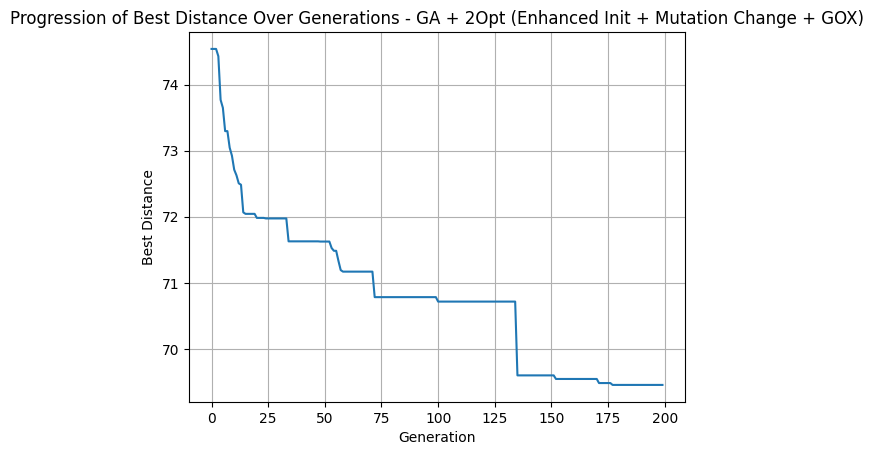

In [ ]:
plt.plot(result_ga['history'])
plt.title("Progression of Best Distance Over Generations - GA + 2Opt (Enhanced Init + Mutation Change + GOX)")
plt.xlabel("Generation")
plt.ylabel("Best Distance")
plt.grid(True)
plt.show()

/tmp/ipython-input-6-968629858.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(routes))


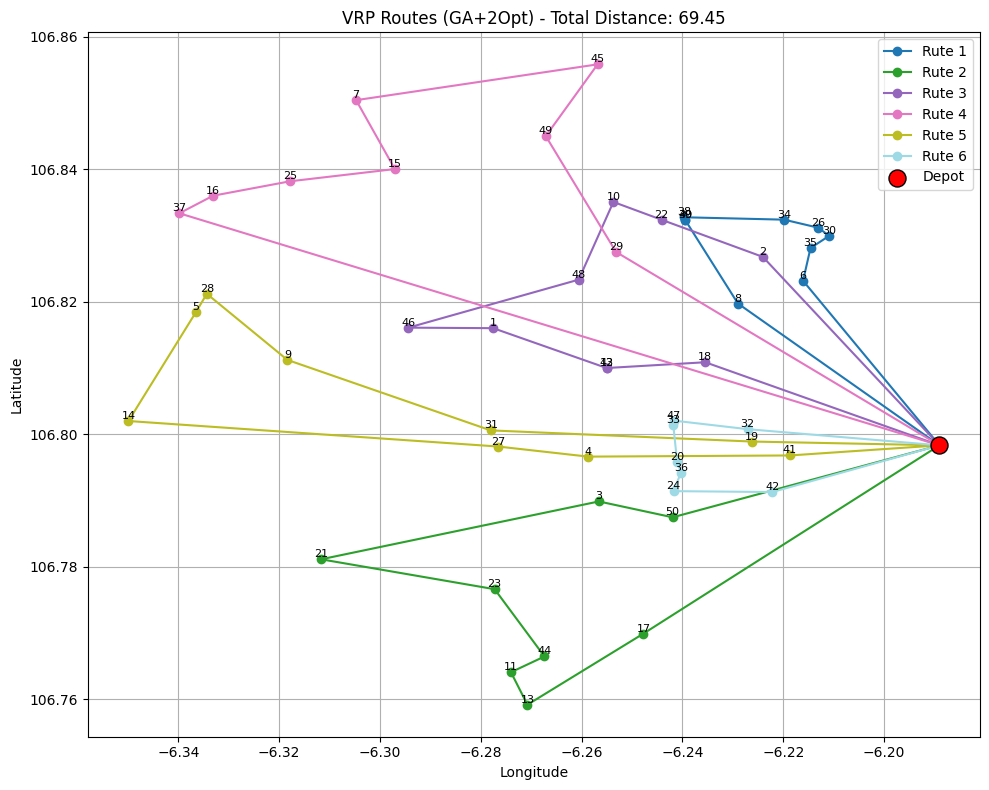

In [ ]:
plot_routes(df.set_index('id'), split_routes(result_ga['best_solution'], demands_processed, vehicle_capacity), title=f"VRP Routes (GA+2Opt) - Total Distance: {result_ga['best_distance']:.2f}")

In [ ]:
print("\n--- Memplot Rute Hasil GA di Folium ---")
ga_folium_map = plot_routes_folium_v2(
    df = df.set_index('id'),
    routes = best_routes_ga_for_display,
    title="VRP Routes (Enhanced GA + 2Opt)"
)

ga_folium_map


--- Memplot Rute Hasil GA di Folium ---


# **Implementasi ACO (Viggo)**

## Algoritma

In [ ]:
def run_aco_vrp(
    demands,
    distance_matrix,
    vehicle_capacity=80,
    n_ants=30,
    n_iterations=200,
    alpha=1.0,
    beta=5.0,
    evaporation_rate=0.5,
    Q=100,
    elitism_weight=2.0
):
    import numpy as np
    import random
    import time

    if not isinstance(demands, dict):
        raise TypeError("demands must be a dictionary mapping customer_id to demand_value.")

    depot_id = 0
    customer_ids = [k for k in demands.keys() if k != depot_id]
    matrix_size = distance_matrix.shape[0]

    pheromone = np.ones((matrix_size, matrix_size))

    best_distance = float("inf")
    best_solution = None

    history = []
    time_history = []
    start_time = time.time()

    def split_routes_aco(path_chromosome):
        routes = []
        current_route = []
        current_load = 0
        for customer_id in path_chromosome:
            demand = demands.get(customer_id, 0)
            if current_load + demand <= vehicle_capacity:
                current_route.append(customer_id)
                current_load += demand
            else:
                if current_route:
                    routes.append([depot_id] + current_route + [depot_id])
                current_route = [customer_id]
                current_load = demand
        if current_route:
            routes.append([depot_id] + current_route + [depot_id])
        return routes

    def total_route_distance_aco(routes_list):
        total = 0.0
        for route in routes_list:
            for i in range(len(route) - 1):
                a, b = route[i], route[i + 1]
                if a < matrix_size and b < matrix_size:
                    total += distance_matrix[a][b]
                else:
                    return float('inf')
        return total

    for iteration in range(n_iterations):
        all_solutions = []

        for _ in range(n_ants):
            unvisited = set(customer_ids)
            current_node = depot_id
            path = []

            while unvisited:
                probabilities = []
                denom = 0.0
                reachable = [j for j in unvisited if j < matrix_size]
                for j in reachable:
                    dist = distance_matrix[current_node][j]
                    eta = (1.0 / dist) ** beta if dist != 0 else (1.0 / 1e-9) ** beta
                    tau = pheromone[current_node][j] ** alpha
                    prob = tau * eta
                    probabilities.append((j, prob))
                    denom += prob

                if denom == 0:
                    if reachable:
                        next_node = random.choice(reachable)
                    else:
                        break
                else:
                    probs = [p[1] / denom for p in probabilities]
                    choices = [p[0] for p in probabilities]
                    if any(np.isnan(probs)) or any(np.isinf(probs)):
                        next_node = random.choice(choices)
                    else:
                        next_node = random.choices(choices, weights=probs, k=1)[0]

                path.append(next_node)
                unvisited.remove(next_node)
                current_node = next_node

            routes = split_routes_aco(path)
            dist = total_route_distance_aco(routes)

            if dist == float('inf'):
                continue

            all_solutions.append((path, routes, dist))

            if dist < best_distance:
                best_distance = dist
                best_solution = routes

        # === Evaporasi
        pheromone *= (1 - evaporation_rate)

        # === Deposit pheromone oleh semut
        for path, routes, dist in all_solutions:
            deposit = Q / (dist if dist != 0 else 1e-9)
            full_path = []
            for r in routes:
                full_path.extend(r)
            for i in range(len(full_path) - 1):
                a, b = full_path[i], full_path[i + 1]
                if a < matrix_size and b < matrix_size:
                    pheromone[a][b] += deposit
                    pheromone[b][a] += deposit

        # === Elitism: deposit dari best_solution global
        if best_solution:
            elite_deposit = (elitism_weight * Q) / (best_distance if best_distance != 0 else 1e-9)
            full_path = []
            for r in best_solution:
                full_path.extend(r)
            for i in range(len(full_path) - 1):
                a, b = full_path[i], full_path[i + 1]
                if a < matrix_size and b < matrix_size:
                    pheromone[a][b] += elite_deposit
                    pheromone[b][a] += elite_deposit

        history.append(best_distance)
        time_history.append(time.time() - start_time)

    return {
        "best_routes": best_solution,
        "best_distance": best_distance,
        "history": history,
        "time": time_history
    }


## Hasil

In [ ]:
result_aco = run_aco_vrp(
    demands=demands_processed,
    distance_matrix=distance_matrix,
    vehicle_capacity=80,
    n_ants=50,
    n_iterations=200,
    alpha=0.8,
    beta=2.0,
    evaporation_rate=0.6,
    Q=100,
    elitism_weight=1.0
)

In [ ]:
print(f"Best Total Distance: {result_aco['best_distance']:.2f} km")

print("\nBest Routes (ACO):")
total_customers_served = 0
for i, route in enumerate(result_aco['best_routes']):
    route_cost = calculate_route_distance(route, distance_matrix, depot_id)

    customers_in_this_route = [node for node in route if node != depot_id]
    route_load = sum(demands_processed.get(c, 0) for c in customers_in_this_route)

    print(f"  Rute {i+1}: {route} (Cost: {route_cost:.2f}, Load: {route_load}/{vehicle_capacity})")
    total_customers_served += len(customers_in_this_route)

print(f"\nTotal Pelanggan Terlayani: {total_customers_served}")
print(f"Jumlah Rute: {len(result_aco['best_routes'])}")

Best Total Distance: 70.31 km

Best Routes (ACO):
  Rute 1: [0, 20, 36, 24, 42, 41, 19, 32, 33, 47, 0] (Cost: 6.29, Load: 80/80)
  Rute 2: [0, 12, 43, 1, 46, 9, 14, 31, 27, 4, 0] (Cost: 11.84, Load: 79/80)
  Rute 3: [0, 3, 50, 23, 21, 17, 44, 11, 13, 0] (Cost: 14.89, Load: 72/80)
  Rute 4: [0, 49, 45, 7, 15, 25, 16, 37, 28, 5, 0] (Cost: 18.39, Load: 80/80)
  Rute 5: [0, 10, 22, 39, 40, 38, 34, 26, 30, 35, 0] (Cost: 9.91, Load: 80/80)
  Rute 6: [0, 6, 2, 29, 48, 8, 18, 0] (Cost: 8.98, Load: 56/80)

Total Pelanggan Terlayani: 50
Jumlah Rute: 6


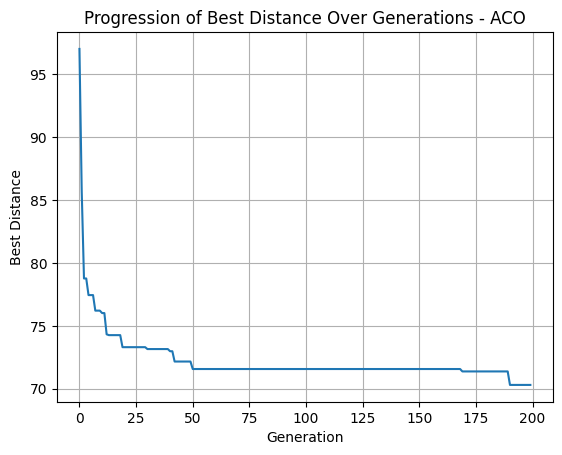

In [ ]:
import matplotlib.pyplot as plt

plt.plot(result_aco['history'])
plt.title("Progression of Best Distance Over Generations - ACO")
plt.xlabel("Generation")
plt.ylabel("Best Distance")
plt.grid(True)
plt.show()


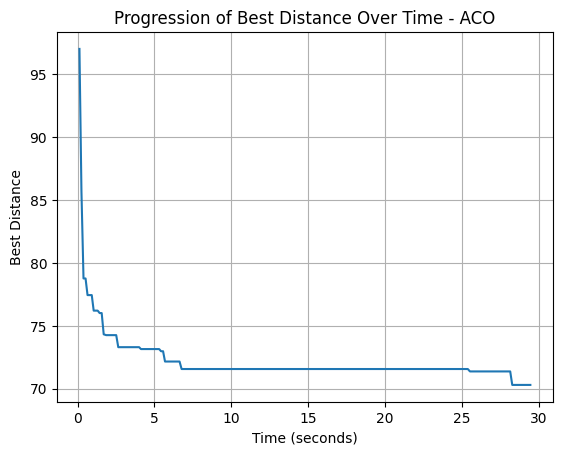

In [ ]:
plt.plot(result_aco['time'], result_aco['history'])
plt.title("Progression of Best Distance Over Time - ACO")
plt.xlabel("Time (seconds)")
plt.ylabel("Best Distance")
plt.grid(True)
plt.show()


/tmp/ipython-input-6-968629858.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(routes))


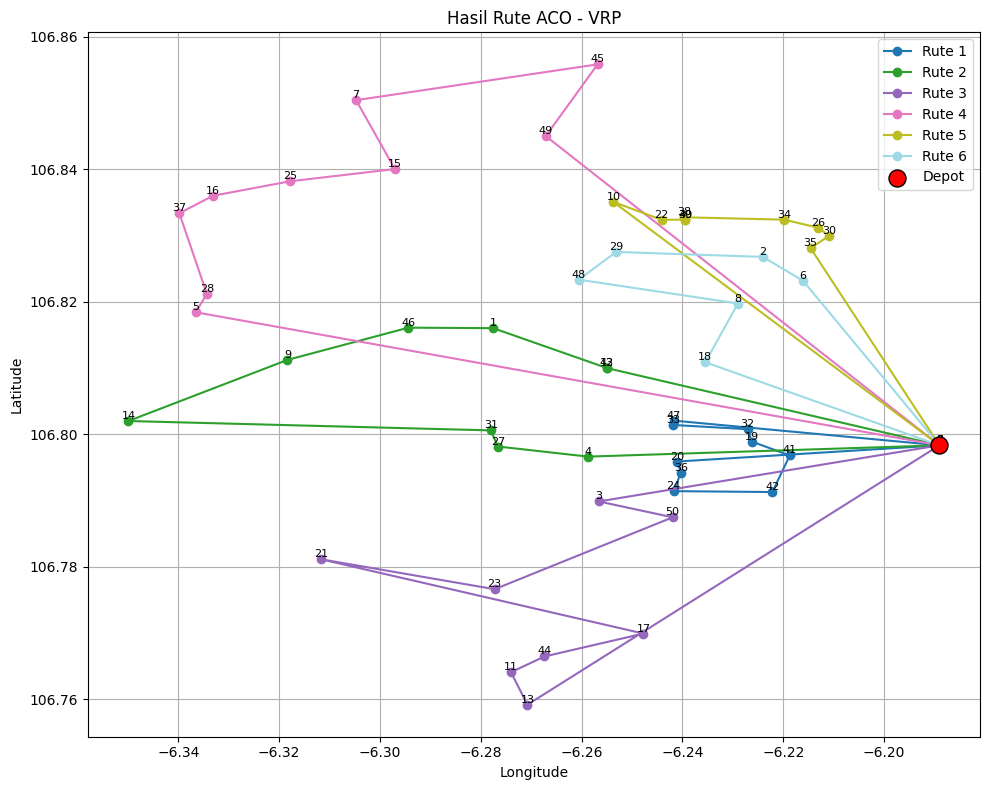

In [ ]:
plot_routes(df.set_index('id'), result_aco["best_routes"], title="Hasil Rute ACO - VRP")

In [ ]:
aco_map = plot_routes_folium_v2(
    df=df.set_index('id'),
    routes=result_aco["best_routes"],
    title="VRP ACO"
)

aco_map

# **Implementasi Tabu Search (Mirna)**

## Algoritma

In [ ]:
def tabu_search_vrp(
    demands,
    distance_matrix,
    vehicle_capacity=80,
    max_iterations=200,
    tabu_tenure=10
):
    if not isinstance(demands, dict):
        raise TypeError("demands must be a dictionary mapping customer_id to demand_value.")

    depot_id = 0
    all_customer_ids = [k for k in demands.keys() if k != depot_id]
    matrix_size = distance_matrix.shape[0]

    # === Fungsi-fungsi pembantu ===
    def initial_solution():
        customers = deepcopy(all_customer_ids)
        random.shuffle(customers)
        return customers

    def split_routes(chromosome):
        routes, current_route, current_load = [], [], 0
        for cid in chromosome:
            demand = demands.get(cid, 0)
            if current_load + demand > vehicle_capacity:
                if current_route:
                    routes.append([depot_id] + current_route + [depot_id])
                current_route, current_load = [cid], demand
            else:
                current_route.append(cid)
                current_load += demand
        if current_route:
            routes.append([depot_id] + current_route + [depot_id])
        return routes

    def route_distance(route):
        return sum(
            distance_matrix[route[i]][route[i+1]]
            for i in range(len(route) - 1)
            if route[i] < matrix_size and route[i+1] < matrix_size
        )

    def total_distance(chromosome):
        return sum(route_distance(r) for r in split_routes(chromosome))

    def get_neighbors(chromosome):
        neighbors = []
        for i in range(len(chromosome)):
            for j in range(i + 1, len(chromosome)):
                neighbor = chromosome[:]
                neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                move = tuple(sorted((chromosome[i], chromosome[j])))
                neighbors.append((neighbor, move))
        return neighbors

    # === Inisialisasi ===
    current = initial_solution()
    best = deepcopy(current)
    best_cost = total_distance(current)
    best_routes = split_routes(best)
    tabu_list = []

    history = [best_cost]
    time_history = [0.0]
    start_time = time.time()

    # === Iterasi Tabu Search ===
    for iteration in range(max_iterations):
        neighbors = get_neighbors(current)
        best_neighbor, best_neighbor_cost, best_move = None, float('inf'), None

        for neighbor, move in neighbors:
            cost = total_distance(neighbor)
            if move not in tabu_list or cost < best_cost:  # Aspiration
                if cost < best_neighbor_cost:
                    best_neighbor, best_neighbor_cost, best_move = neighbor, cost, move

        if best_neighbor is None:
            # Jika tidak ada neighbor yang valid
            sisa_iterasi = max_iterations - len(history)
            history.extend([best_cost] * sisa_iterasi)
            time_history.extend([time.time() - start_time] * sisa_iterasi)
            break

        current = best_neighbor
        tabu_list.append(best_move)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)

        if best_neighbor_cost < best_cost:
            best, best_cost = deepcopy(current), best_neighbor_cost
            best_routes = split_routes(best)

        history.append(best_cost)
        time_history.append(time.time() - start_time)

    return {
        "best_individual": best,
        "best_routes": best_routes,
        "best_distance": best_cost,
        "history": history,
        "time": time_history
    }


## Hasil

In [ ]:
tabu_result = tabu_search_vrp(
    demands=demands_processed,
    distance_matrix=distance_matrix,
    vehicle_capacity=80,
    max_iterations=500,
    tabu_tenure=15
)

In [ ]:
# Hitung total jarak semua rute (include depot) - Pastikan fungsi ini sudah didefinisikan
def calculate_total_distance(routes, dist_matrix, depot):
    total = 0
    for route in routes:
        prev = depot
        for customer in route:
            total += dist_matrix[prev][customer]
            prev = customer
        total += dist_matrix[prev][depot]  # kembali ke depot
    return total

# Make sure this function is defined and in scope
def calculate_route_distance(route, dist_matrix, depot_id):
    """Calculates the total distance of a single route including depot trips."""
    cost = 0.0
    matrix_size = dist_matrix.shape[0] # Ensure matrix_size is available or inferred

    if not route or len(route) < 2:
        return 0.0

    # Ensure the route starts and ends with the depot for calculation
    # This assumes the 'route' passed in is already in the format [depot, cust1, ..., depot]
    # If it's just a list of customers, the logic needs to be adjusted.
    # Based on the split_routes function, the routes passed to calculate_route_distance
    # seem to already include the depot at the start and end.

    for i in range(len(route) - 1):
        node_from = route[i]
        node_to = route[i+1]

        if node_from < matrix_size and node_to < matrix_size:
            cost += dist_matrix[node_from][node_to]
        else:
             print(f"Warning: Node ID {node_from} or {node_to} out of bounds for distance_matrix (size {matrix_size}) in route {route}.")
             return float('inf')

    return cost


print(f"Best Total Distance: {tabu_result['best_distance']:.2f} km")

print("\nBest Routes (Tabu Search):")
total_customers_served = 0
for i, route in enumerate(tabu_result['best_routes']):
    # 'route' di sini seharusnya sudah dalam format [0, customer1, customer2, 0]

    route_cost = calculate_route_distance(route, distance_matrix, depot_id)

    # Mengekstrak hanya pelanggan dari rute untuk perhitungan beban
    customers_in_this_route = [node for node in route if node != depot_id]
    route_load = sum(demands_processed.get(c, 0) for c in customers_in_this_route)

    print(f"  Rute {i+1}: {route} (Cost: {route_cost:.2f}, Load: {route_load}/{vehicle_capacity})")
    total_customers_served += len(customers_in_this_route)

print(f"\nTotal Pelanggan Terlayani: {total_customers_served}")
print(f"Jumlah Rute: {len(tabu_result['best_routes'])}")

Best Total Distance: 77.61 km

Best Routes (Tabu Search):
  Rute 1: [0, 47, 12, 1, 21, 23, 44, 11, 13, 17, 0] (Cost: 16.11, Load: 80/80)
  Rute 2: [0, 42, 24, 36, 20, 4, 31, 27, 3, 50, 0] (Cost: 7.81, Load: 79/80)
  Rute 3: [0, 41, 19, 32, 6, 34, 26, 30, 35, 0] (Cost: 9.12, Load: 74/80)
  Rute 4: [0, 43, 46, 37, 16, 25, 10, 22, 2, 0] (Cost: 14.03, Load: 72/80)
  Rute 5: [0, 33, 14, 9, 5, 28, 48, 29, 8, 0] (Cost: 14.73, Load: 72/80)
  Rute 6: [0, 38, 39, 40, 49, 45, 7, 15, 18, 0] (Cost: 15.80, Load: 70/80)

Total Pelanggan Terlayani: 50
Jumlah Rute: 6


/tmp/ipython-input-6-968629858.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(routes))


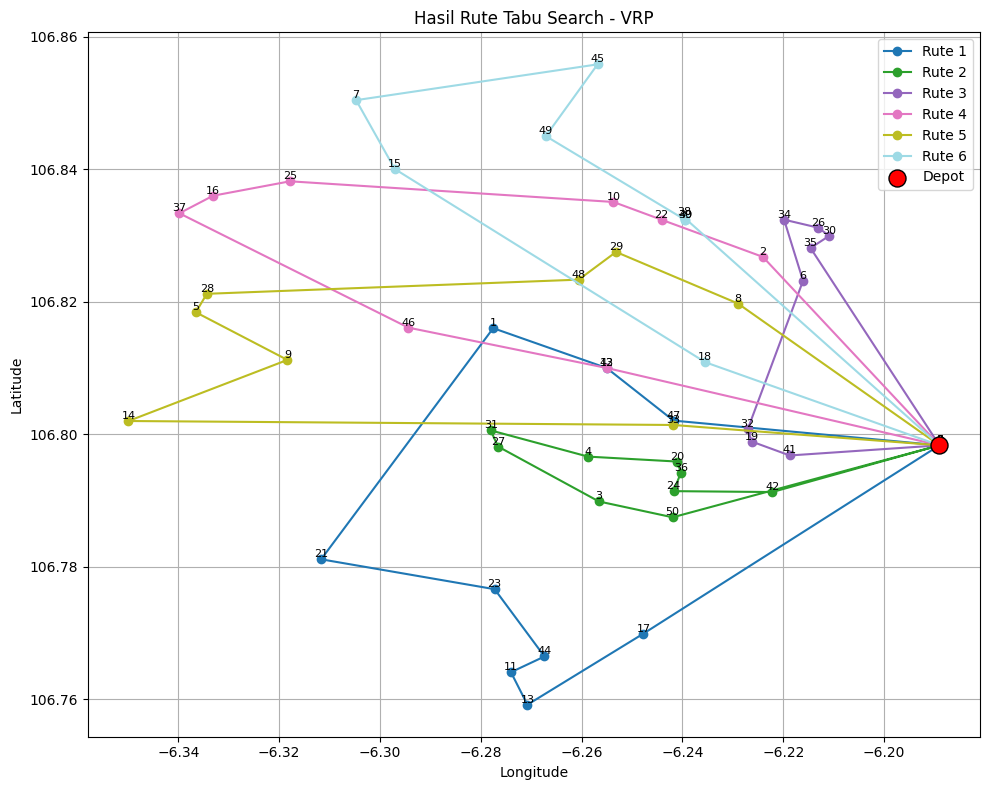

In [ ]:
# Plot hasil
plot_routes(df.set_index('id'), tabu_result["best_routes"], title="Hasil Rute Tabu Search - VRP")

In [ ]:
tabu_map = plot_routes_folium_v2(
    df=df.set_index('id'),
    routes=tabu_result["best_routes"],
    title="VRP - Tabu Search"
)

tabu_map

## TUNING MIRNA IRAWAN^^

In [ ]:
# import time
# import numpy as np
# import pandas as pd

# def evaluate_tabu_config(demands, distance_matrix, vehicle_capacity, tenure, iterations, n_runs=5):
#     distances = []
#     for _ in range(n_runs):
#         start = time.time()
#         result = tabu_search_vrp(
#             demands=demands,
#             distance_matrix=distance_matrix,
#             vehicle_capacity=vehicle_capacity,
#             max_iterations=iterations,
#             tabu_tenure=tenure
#         )
#         distances.append(result['best_distance'])
#     return {
#         'tenure': tenure,
#         'iterations': iterations,
#         'mean_distance': np.mean(distances),
#         'std_distance': np.std(distances)
#     }

# # Grid search values
# tenure_values = [5, 10, 15, 20]
# iteration_values = [100, 200, 300, 500]

# # Run tuning
# results = []
# for tenure in tenure_values:
#     for iterations in iteration_values:
#         print(f"Evaluating tenure={tenure}, iterations={iterations}...")
#         stats = evaluate_tabu_config(
#             demands=demands_processed,
#             distance_matrix=distance_matrix,
#             vehicle_capacity=80,
#             tenure=tenure,
#             iterations=iterations,
#             n_runs=5
#         )
#         results.append(stats)

# # Convert to DataFrame
# tuning_df = pd.DataFrame(results)

# # Show best configs
# print("\n=== Top 5 Kombinasi Tabu Search Berdasarkan Jarak Rata-rata ===")
# display(tuning_df.sort_values(by="mean_distance").head(5))


# **Implementasi SA (Dinan)**

## Algoritma

In [ ]:
def generate_initial_permutation_sa(customer_ids, distance_matrix, depot_idx=0, alpha=0.7):
    """
    Generates a hybrid initial permutation:
    - alpha proportion of customers selected with nearest neighbor
    - (1 - alpha) randomly shuffled

    Parameters:
    - customer_ids: List of customer node IDs (excluding depot)
    - distance_matrix: Matrix of distances
    - depot_idx: Index of depot
    - alpha: Proportion of customers selected with NN before adding the rest randomly

    Returns:
    - Hybrid permutation of customer IDs
    """
    total = len(customer_ids)
    count_nn = int(total * alpha)
    unvisited = set(customer_ids)
    current_node = depot_idx
    permutation = []

    while len(permutation) < count_nn and unvisited:
        nearest = min(unvisited, key=lambda x: distance_matrix[current_node][x])
        permutation.append(nearest)
        unvisited.remove(nearest)
        current_node = nearest

    remaining = list(unvisited)
    random.shuffle(remaining)
    permutation += remaining

    return permutation


def split_permutation_into_routes_sa(permutation, demands, capacity, depot_idx):
    """Splits a customer permutation into routes based on vehicle capacity."""
    routes = []
    current_route = []
    current_load = 0

    for customer_id in permutation:
        demand = demands.get(customer_id, 0) # Menggunakan .get() untuk keamanan

        if current_load + demand > capacity:
            if current_route: # Pastikan ada pelanggan sebelum menambahkan rute
                 routes.append([depot_idx] + current_route + [depot_idx])
            current_route = [customer_id]
            current_load = demand
        else:
            current_route.append(customer_id)
            current_load += demand

    if current_route: # Tambahkan rute terakhir jika ada pelanggan
         routes.append([depot_idx] + current_route + [depot_idx])

    return routes

def calculate_single_route_cost_sa(route_with_depot, distance_matrix, depot_idx):
    """Calculates the total distance of a single route including depot trips."""
    cost = 0.0
    matrix_size = distance_matrix.shape[0]

    if not route_with_depot or len(route_with_depot) < 2:
        # Rute hanya [depot] atau kosong tidak menambah cost
        return 0.0

    # Pastikan rute dimulai dan diakhiri dengan depot
    # Jika tidak, ini bisa menjadi indikasi masalah, atau rute parsial
    # Untuk perhitungan cost, kita hanya menjumlahkan jarak antar node berurutan
    # Jika format [depot, cust1, ..., depot] dijamin, ini sudah benar
    # Jika tidak, mungkin perlu validasi lebih lanjut di sini

    for i in range(len(route_with_depot) - 1):
        node_from = route_with_depot[i]
        node_to = route_with_depot[i+1]

        # Pastikan indeks ada dalam batas distance_matrix
        if node_from < matrix_size and node_to < matrix_size:
            cost += distance_matrix[node_from][node_to]
        else:
             # Jika ada ID di luar batas matriks, ini adalah rute yang tidak valid
             print(f"Warning: SA - Node ID {node_from} or {node_to} out of bounds for distance_matrix (size {matrix_size}) in route {route_with_depot}.")
             return float('inf') # Berikan penalti yang sangat besar

    return cost

def generate_neighbor_permutation_sa(permutation):
    """Generates a neighbor permutation using swap or 2-opt on the customer sequence."""
    neighbor = list(permutation)
    size = len(neighbor)

    if size < 2:
        return neighbor # Tidak bisa membuat tetangga jika kurang dari 2 pelanggan

    # Pilih antara swap dan 2-opt inversion secara acak
    if random.random() < 0.5: # Swap
        idx1, idx2 = random.sample(range(size), 2)
        neighbor[idx1], neighbor[idx2] = neighbor[idx2], neighbor[idx1]
    else: # 2-opt style inversion
         # Pastikan start < end
         start, end = sorted(random.sample(range(size), 2))
         # Pastikan ada segmen untuk dibalik (start < end)
         if start < end:
             neighbor[start:end+1] = neighbor[start:end+1][::-1]
         # Jika start == end, tidak ada perubahan, jadi tidak perlu else
         # Jika size = 2, random.sample(range(2), 2) akan menghasilkan (0, 1) atau (1, 0),
         # sorted akan menghasilkan (0, 1). start=0, end=1. neighbour[0:2][::-1] akan membalik list
         # dengan 2 elemen, ini sama dengan swap, jadi 2-opt inversion juga bekerja untuk size 2.


    return neighbor

def simulated_annealing_vrp(
    demands,
    distance_matrix,
    vehicle_capacity=80,
    depot_idx=0,
    initial_temp=100,
    cooling_rate=0.995,
    stopping_temp=0.1,
    max_iter=float('inf'),
    time_limit_sec=None,
    alpha=0.7  # proporsi pelanggan yang dipilih dengan NN dalam hybrid
):
    if not isinstance(demands, dict):
        raise TypeError("demands must be a dictionary mapping customer_id to demand_value.")

    matrix_size = distance_matrix.shape[0]
    customer_ids_for_sa = [k for k in demands.keys() if k != depot_idx and demands.get(k, 0) > 0 and k < matrix_size]

    if depot_idx >= matrix_size:
        print(f"Error: Depot ID {depot_idx} out of bounds for distance_matrix (size {matrix_size}). Cannot run SA.")
        return {
            "best_permutation": [],
            "best_routes": [],
            "best_distance": float('inf'),
            "history": [],
            "time": []
        }

    if not customer_ids_for_sa:
        print("Warning: No valid customers with demand found for SA after filtering.")
        return {
            "best_permutation": [],
            "best_routes": [],
            "best_distance": 0.0,
            "history": [0.0],
            "time": [0.0]
        }

    # Gunakan hybrid NN + random secara default
    current_permutation = generate_initial_permutation_sa(
        customer_ids=customer_ids_for_sa,
        distance_matrix=distance_matrix,
        depot_idx=depot_idx,
        alpha=alpha
    )

    current_routes = split_permutation_into_routes_sa(current_permutation, demands, vehicle_capacity, depot_idx)
    current_cost = sum(calculate_single_route_cost_sa(r, distance_matrix, depot_idx) for r in current_routes)

    best_permutation = list(current_permutation)
    best_routes = list(current_routes)
    best_cost = current_cost

    history = [best_cost]
    time_history = [0.0]

    temp = initial_temp
    iteration = 0
    start_time = time.time()

    while temp > stopping_temp and iteration < max_iter:
        elapsed_time = time.time() - start_time
        if time_limit_sec is not None and elapsed_time > time_limit_sec:
            print(f"SA Time limit ({time_limit_sec}s) reached. Stopping.")
            break

        neighbor_permutation = generate_neighbor_permutation_sa(current_permutation)
        neighbor_routes = split_permutation_into_routes_sa(neighbor_permutation, demands, vehicle_capacity, depot_idx)
        neighbor_cost = sum(calculate_single_route_cost_sa(r, distance_matrix, depot_idx) for r in neighbor_routes)

        if neighbor_cost == float('inf'):
            delta = float('inf')
        else:
            delta = neighbor_cost - current_cost

        if delta < 0 or (temp > 0 and random.uniform(0, 1) < np.exp(-delta / temp)):
            current_permutation = neighbor_permutation
            current_routes = neighbor_routes
            current_cost = neighbor_cost

            if current_cost < best_cost:
                best_permutation = list(current_permutation)
                best_routes = list(current_routes)
                best_cost = current_cost

        temp *= cooling_rate
        iteration += 1
        history.append(best_cost)
        time_history.append(time.time() - start_time)

    return {
        "best_permutation": best_permutation,
        "best_routes": best_routes,
        "best_distance": best_cost,
        "history": history,
        "time": time_history
    }


## Hasil

In [ ]:
# --- Panggilan Fungsi Simulated Annealing ---
print("\n--- Menjalankan Simulated Annealing ---")
sa_result = simulated_annealing_vrp(
    demands=demands_processed,
    distance_matrix=distance_matrix,
    vehicle_capacity=vehicle_capacity,
    depot_idx=depot_id,
    initial_temp=500,
    cooling_rate=0.999,
    stopping_temp=0.001,
    max_iter=20000
)

sa_history = sa_result['history']
sa_time = sa_result['time']


--- Menjalankan Simulated Annealing ---


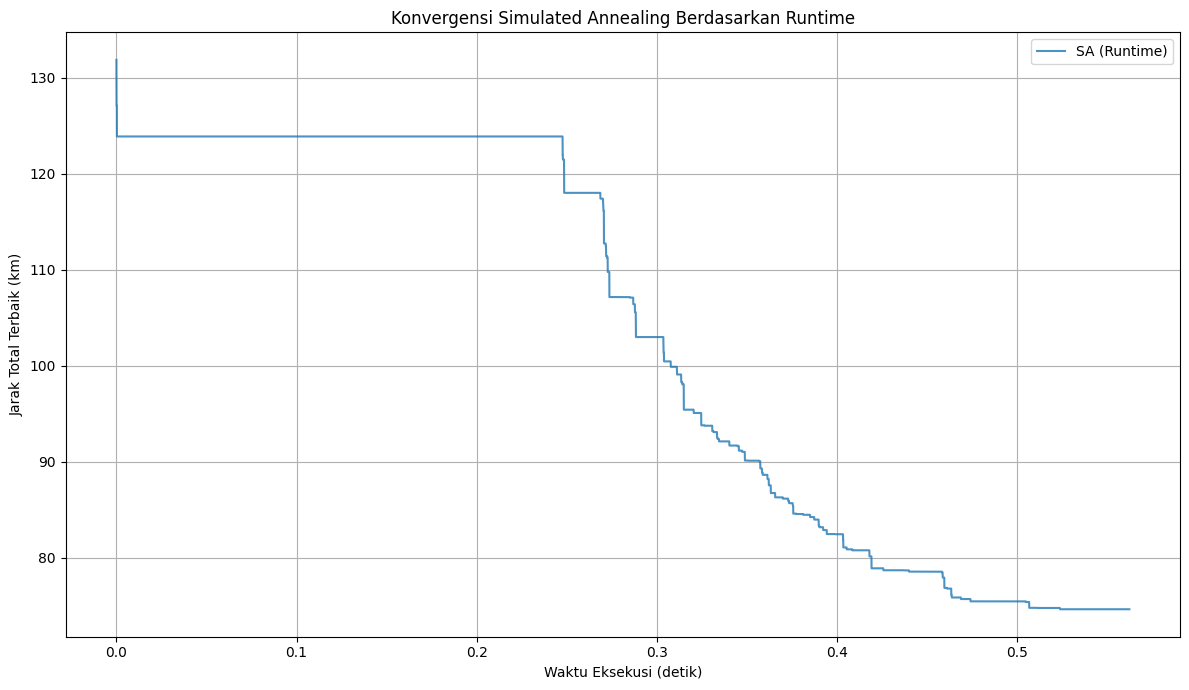

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(sa_time, sa_history, label='SA (Runtime)', alpha=0.8)

plt.title('Konvergensi Simulated Annealing Berdasarkan Runtime')
plt.xlabel('Waktu Eksekusi (detik)')
plt.ylabel('Jarak Total Terbaik (km)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# file ipython-input-21-987576604
# Asumsi: sa_result, distance_matrix, depot_id, demands_processed, vehicle_capacity sudah terdefinisi

print(f"Best Total Distance: {sa_result['best_distance']:.2f} km")

print("\nBest Routes (Simulated Annealing):")
total_customers_served = 0
for i, route in enumerate(sa_result['best_routes']):
        # 'route' di sini seharusnya sudah dalam format [0, customer1, customer2, 0]

    # !!! PERBAIKAN DISINI: GANTI calculate_route_distance
    # dengan calculate_single_route_cost_sa yang khusus untuk SA
    route_cost = calculate_single_route_cost_sa(route, distance_matrix, depot_id) # <-- Pastikan ini sudah diganti!

        # Mengekstrak hanya pelanggan dari rute untuk perhitungan beban
    customers_in_this_route = [node for node in route if node != depot_id]
    route_load = sum(demands_processed.get(c, 0) for c in customers_in_this_route)

    print(f"  Rute {i+1}: {route} (Cost: {route_cost:.2f}, Load: {route_load}/{vehicle_capacity})")
    total_customers_served += len(customers_in_this_route)

print(f"\nTotal Pelanggan Terlayani: {total_customers_served}")
print(f"Jumlah Rute: {len(sa_result['best_routes'])}")

Best Total Distance: 74.63 km

Best Routes (Simulated Annealing):
  Rute 1: [0, 42, 50, 17, 44, 13, 11, 23, 3, 24, 0] (Cost: 11.54, Load: 80/80)
  Rute 2: [0, 8, 10, 49, 45, 7, 15, 25, 18, 0] (Cost: 16.64, Load: 72/80)
  Rute 3: [0, 19, 20, 9, 5, 28, 37, 16, 46, 0] (Cost: 14.29, Load: 71/80)
  Rute 4: [0, 32, 12, 43, 1, 48, 29, 22, 40, 35, 0] (Cost: 10.21, Load: 80/80)
  Rute 5: [0, 33, 47, 31, 14, 21, 27, 4, 36, 41, 0] (Cost: 13.09, Load: 79/80)
  Rute 6: [0, 30, 26, 34, 38, 39, 2, 6, 0] (Cost: 8.85, Load: 65/80)

Total Pelanggan Terlayani: 50
Jumlah Rute: 6


/tmp/ipython-input-6-968629858.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(routes))


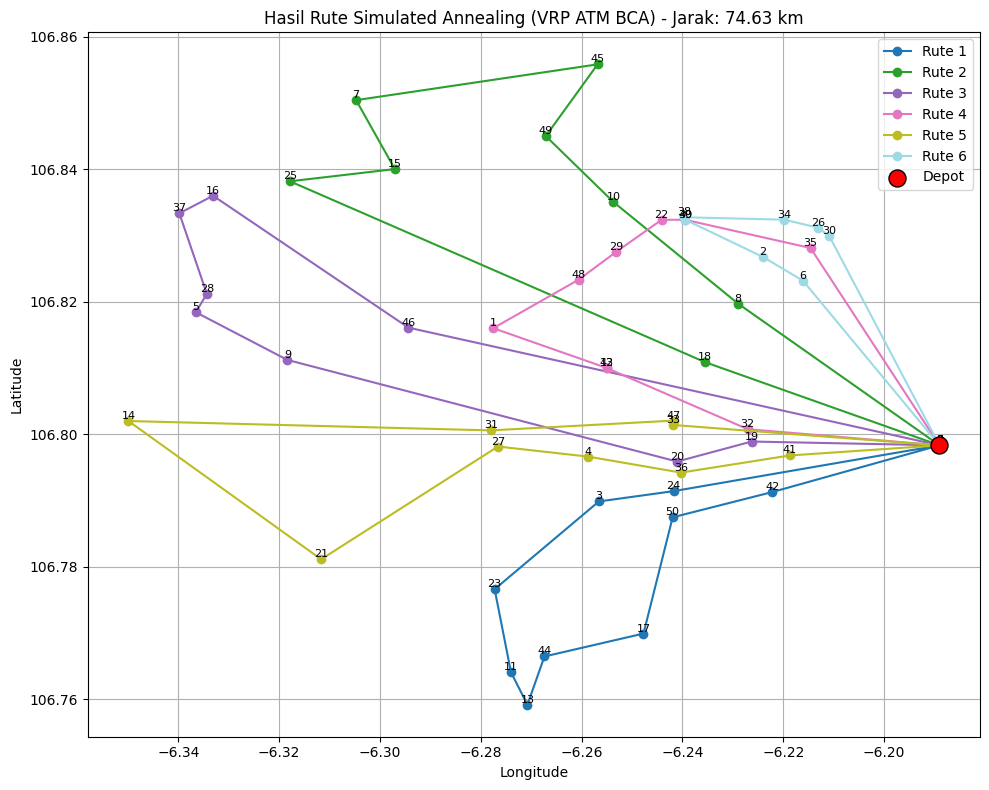

In [ ]:
plot_routes(
    df.set_index('id'),
    sa_result["best_routes"], # Langsung gunakan best_routes dari hasil SA
    depot_id,
    title=f"Hasil Rute Simulated Annealing (VRP ATM BCA) - Jarak: {sa_result['best_distance']:.2f} km"
)

In [ ]:
sa_map = plot_routes_folium_v2(
    df=df.set_index('id'),
    routes=sa_result["best_routes"],
    title="VRP - SA"
)

sa_map

## Percobaan Tunning SA

In [ ]:
# # --- Experiment 1: Default Parameters ---
# print("\n--- Running SA Experiment 1 (Default) ---")
# sa_result_exp1 = simulated_annealing_vrp(
#     demands=demands_processed,
#     distance_matrix=distance_matrix,
#     vehicle_capacity=vehicle_capacity,
#     depot_idx=depot_id,
#     initial_temp=100,
#     cooling_rate=0.995,
#     stopping_temp=0.1,
#     max_iter=5000
# )
# print(f"Exp 1 Best Distance: {sa_result_exp1['best_distance']:.2f} km")
# # Tampilkan SEMUA rute terbaik untuk exp 1
# print("Exp 1 Best Routes:")
# for i, route in enumerate(sa_result_exp1['best_routes']): # Hapus [:3]
#     # Hitung cost dan load untuk rute ini agar informasi lengkap
#     route_cost = calculate_single_route_cost_sa(route, distance_matrix, depot_id)
#     customers_in_this_route = [node for node in route if node != depot_id]
#     route_load = sum(demands_processed.get(c, 0) for c in customers_in_this_route)
#     print(f"  Route {i+1}: {route} (Cost: {route_cost:.2f}, Load: {route_load}/{vehicle_capacity})")

# print(f"Total Routes in Exp 1: {len(sa_result_exp1['best_routes'])}")


In [ ]:
# # --- Experiment 2: Higher initial_temp, Slower cooling_rate, More iterations ---
# print("\n--- Running SA Experiment 2 ---")
# sa_result_exp2 = simulated_annealing_vrp(
#     demands=demands_processed,
#     distance_matrix=distance_matrix,
#     vehicle_capacity=vehicle_capacity,
#     depot_idx=depot_id,
#     initial_temp=500,
#     cooling_rate=0.999,
#     stopping_temp=0.001,
#     max_iter=20000
# )
# print(f"Exp 2 Best Distance: {sa_result_exp2['best_distance']:.2f} km")
# # Tampilkan SEMUA rute terbaik untuk exp 2
# print("Exp 2 Best Routes:")
# for i, route in enumerate(sa_result_exp2['best_routes']): # Hapus [:3]
#     route_cost = calculate_single_route_cost_sa(route, distance_matrix, depot_id)
#     customers_in_this_route = [node for node in route if node != depot_id]
#     route_load = sum(demands_processed.get(c, 0) for c in customers_in_this_route)
#     print(f"  Route {i+1}: {route} (Cost: {route_cost:.2f}, Load: {route_load}/{vehicle_capacity})")

# print(f"Total Routes in Exp 2: {len(sa_result_exp2['best_routes'])}")



In [ ]:
# # --- Experiment 3: Using Time Limit ---
# print("\n--- Running SA Experiment 3 (Time Limited) ---")
# sa_result_exp3 = simulated_annealing_vrp(
#     demands=demands_processed,
#     distance_matrix=distance_matrix,
#     vehicle_capacity=vehicle_capacity,
#     depot_idx=depot_id,
#     initial_temp=200,
#     cooling_rate=0.998,
#     stopping_temp=0.1,
#     max_iter=100000,
#     time_limit_sec=60
# )
# print(f"Exp 3 Best Distance: {sa_result_exp3['best_distance']:.2f} km")
# # Tampilkan SEMUA rute terbaik untuk exp 3
# print("Exp 3 Best Routes:")
# for i, route in enumerate(sa_result_exp3['best_routes']): # Hapus [:3]
#     route_cost = calculate_single_route_cost_sa(route, distance_matrix, depot_id)
#     customers_in_this_route = [node for node in route if node != depot_id]
#     route_load = sum(demands_processed.get(c, 0) for c in customers_in_this_route)
#     print(f"  Route {i+1}: {route} (Cost: {route_cost:.2f}, Load: {route_load}/{vehicle_capacity})")

# print(f"Total Routes in Exp 3: {len(sa_result_exp3['best_routes'])}")


In [ ]:
# # # **SA Final Result (Choose Best Experiment)**

# all_results = [sa_result_exp1, sa_result_exp2, sa_result_exp3]
# best_overall_sa_result = min(all_results, key=lambda res: res['best_distance'])

# print("\n--- Best Overall SA Result from Tuning ---")
# print(f"Best Experiment Result: Best Distance = {best_overall_sa_result['best_distance']:.2f} km")
# if best_overall_sa_result == sa_result_exp1: print("  Corresponding Experiment: Experiment 1 (Default)")
# elif best_overall_sa_result == sa_result_exp2: print("  Corresponding Experiment: Experiment 2 (Tuned 1)")
# elif best_overall_sa_result == sa_result_exp3: print("  Corresponding Experiment: Experiment 3 (Time Limited)")

# print("\nBest Routes (Simulated Annealing - Tuned):")
# best_sa_routes_for_display = best_overall_sa_result['best_routes']

# total_customers_served = 0
# for i, route in enumerate(best_sa_routes_for_display):
#     route_cost = calculate_single_route_cost_sa(route, distance_matrix, depot_id)
#     customers_in_this_route = [node for node in route if node != depot_id]
#     route_load = sum(demands_processed.get(c, 0) for c in customers_in_this_route)
#     print(f"  Rute {i+1}: {route} (Cost: {route_cost:.2f}, Load: {route_load}/{vehicle_capacity})")
#     total_customers_served += len(customers_in_this_route)

# print(f"\nTotal Pelanggan Terlayani: {total_customers_served}")
# print(f"Jumlah Rute: {len(best_sa_routes_for_display)}")



# **Evaluasi Konsistensi**

## Boxplot

In [ ]:
# import time

# def evaluate_algorithm(run_func, n_runs=10):
#     distances = []
#     runtimes = []

#     for _ in range(n_runs):
#         start = time.time()
#         result = run_func()
#         end = time.time()

#         distances.append(result['best_distance'])
#         runtimes.append(end - start)

#     return {
#         "min": min(distances),
#         "max": max(distances),
#         "mean": np.mean(distances),
#         "std": np.std(distances),
#         "avg_runtime": np.mean(runtimes),
#         "all_distances": distances,
#         "all_runtimes": runtimes
#     }


In [ ]:
  # # --- Algoritma dan Parameter untuk Evaluasi ---
  # ga_stats = evaluate_algorithm(lambda: enhanced_ga_2opt(
  #     pop_size=150,
  #     num_generations=200,
  #     mutation_rate=0.25,
  #     initialization_heuristic_ratio=0.1,
  #     capacity=vehicle_capacity,
  #     demands=demands_processed,
  #     coordinates=coordinates_processed,
  #     depot_id=depot_id
  # ))

  # aco_stats = evaluate_algorithm(lambda: run_aco_vrp(
  #     demands=demands_processed,
  #     distance_matrix=distance_matrix,
  #     vehicle_capacity=80,
  #     n_ants=50,
  #     n_iterations=200,
  #     alpha=0.8,
  #     beta=2.0,
  #     evaporation_rate=0.6,
  #     Q=100,
  #     elitism_weight=1.0
  # ))

  # tabu_stats = evaluate_algorithm(lambda: tabu_search_vrp(
  #     demands=demands_processed,
  #     distance_matrix=distance_matrix,
  #     vehicle_capacity=vehicle_capacity,
  #     max_iterations=200,
  #     tabu_tenure=10
  # ))

  # sa_stats = evaluate_algorithm(lambda: simulated_annealing_vrp(
  #     demands=demands_processed,
  #     distance_matrix=distance_matrix,
  #     vehicle_capacity=vehicle_capacity,
  #     depot_idx=depot_id,
  #     initial_temp=500,
  #     cooling_rate=0.999,
  #     stopping_temp=0.001,
  #     max_iter=20000
  # ))


  # print("\n=== PERBANDINGAN HASIL ===")
  # print(f"GA     → Mean: {ga_stats['mean']:.2f}, Std: {ga_stats['std']:.2f}, Min: {ga_stats['min']:.2f}, Max: {ga_stats['max']:.2f}, Time: {ga_stats['avg_runtime']:.2f}s")
  # print(f"ACO    → Mean: {aco_stats['mean']:.2f}, Std: {aco_stats['std']:.2f}, Min: {aco_stats['min']:.2f}, Max: {aco_stats['max']:.2f}, Time: {aco_stats['avg_runtime']:.2f}s")
  # print(f"Tabu   → Mean: {tabu_stats['mean']:.2f}, Std: {tabu_stats['std']:.2f}, Min: {tabu_stats['min']:.2f}, Max: {tabu_stats['max']:.2f}, Time: {tabu_stats['avg_runtime']:.2f}s")
  # print(f"SA     → Mean: {sa_stats['mean']:.2f}, Std: {sa_stats['std']:.2f}, Min: {sa_stats['min']:.2f}, Max: {sa_stats['max']:.2f}, Time: {sa_stats['avg_runtime']:.2f}s")

In [ ]:
# data_to_plot = {
#     'GA': ga_stats['all_distances'],
#     'ACO': aco_stats['all_distances'],
#     'Tabu Search': tabu_stats['all_distances'],
#     'SA': sa_stats['all_distances']
# }

# # Konversi dictionary ke Pandas DataFrame
# df_boxplot = pd.DataFrame(data_to_plot)

# # Ambil jumlah run dari salah satu stats (asumsi sama untuk semua)
# n_runs_actual = len(ga_stats['all_distances']) # Atau N_RUNS_EVALUATION jika didefinisikan

# # Buat boxplot
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=df_boxplot, palette='viridis') # 'viridis' adalah pilihan palet warna yang bagus

# plt.title(f'Perbandingan Distribusi Jarak Total Rute Antar Algoritma (N={n_runs_actual} Runs)')
# plt.xlabel('Algoritma')
# plt.ylabel('Jarak Total Rute (km)')
# plt.grid(axis='y', linestyle='--', alpha=0.7) # Tambahkan grid di sumbu Y
# plt.show()

## Convergence Graph (Generation)


Mengumpulkan riwayat konvergensi untuk plotting (persentase progres)...


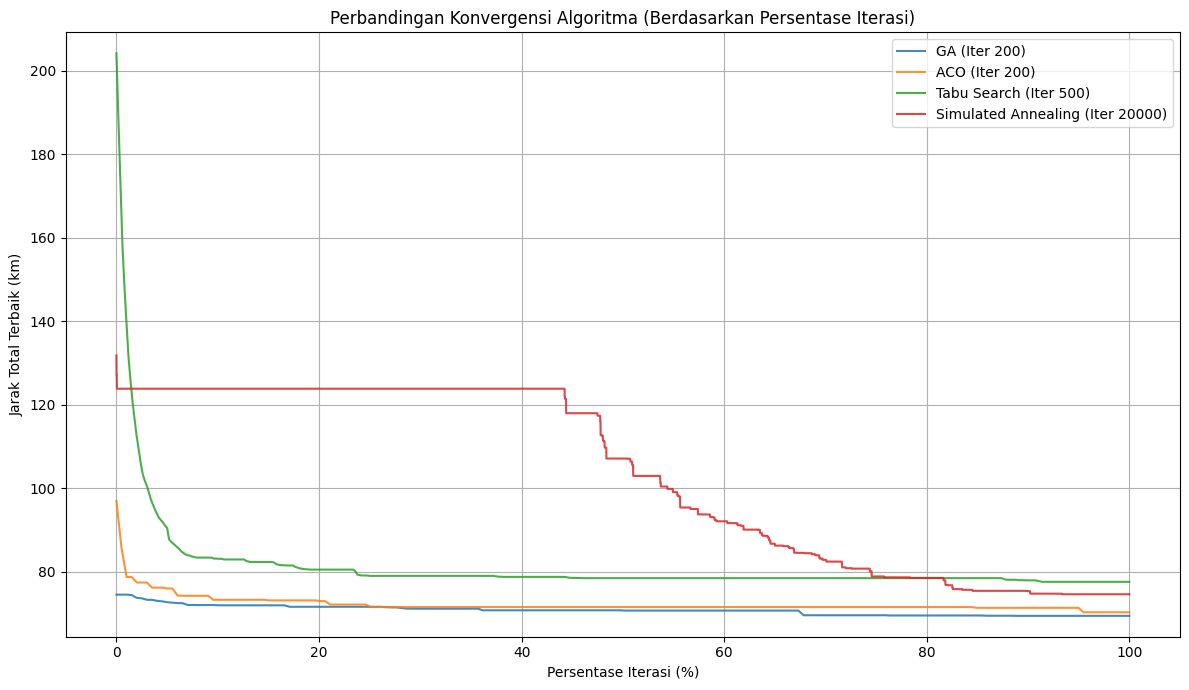

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Siapkan Data History ---
print("\nMengumpulkan riwayat konvergensi untuk plotting (persentase progres)...")

histories = {
    'GA (Iter 200)': result_ga['history'],
    'ACO (Iter 200)': result_aco['history'],
    'Tabu Search (Iter 500)': tabu_result['history'],
    'Simulated Annealing (Iter 20000)': sa_result['history']
}

# --- 2. Plot Progress Konvergensi dalam Persentase Iterasi ---
plt.figure(figsize=(12, 7))

for algo_name, history in histories.items():
    num_iter = len(history)
    progress_pct = np.linspace(0, 100, num_iter)
    plt.plot(progress_pct, history, label=algo_name, alpha=0.85)

plt.title('Perbandingan Konvergensi Algoritma (Berdasarkan Persentase Iterasi)')
plt.xlabel('Persentase Iterasi (%)')
plt.ylabel('Jarak Total Terbaik (km)')
plt.grid(True)

# Atur batas Y biar proporsional
all_histories = sum(histories.values(), [])
if all_histories:
    plt.ylim(bottom=min(all_histories) - 5, top=max(all_histories) + 5)

plt.legend()
plt.tight_layout()
plt.show()


## Convergence Graph (Runtime: 30s)

In [ ]:
# # --- 1. Kumpulkan history dari satu run setiap algoritma KHUSUS untuk Plotting Runtime ---
# print("\nMengumpulkan riwayat konvergensi KHUSUS untuk plotting runtime...")

# GA_RUNTIME_ITERATIONS = 205 # Sesuaikan jumlah generasi GA untuk plot runtime
# ACO_RUNTIME_ITERATIONS = 250 # Sesuaikan jumlah iterasi ACO untuk plot runtime
# TABU_RUNTIME_ITERATIONS = 600 # Sesuaikan jumlah iterasi Tabu Search untuk plot runtime
# SA_RUNTIME_ITERATIONS = 100000000 # Sesuaikan jumlah iterasi SA untuk plot runtime

# # GA parameters (gunakan konfigurasi terbaik Anda: Pop 150, Mut 0.25)
# ga_runtime_params = {
#     'pop_size': 150,
#     'num_generations': GA_RUNTIME_ITERATIONS, # Menggunakan variabel kontrol runtime
#     'mutation_rate': 0.25,
#     'initialization_heuristic_ratio': 0.1,
#     'capacity': vehicle_capacity,
#     'demands': demands_processed,
#     'coordinates': coordinates_processed,
#     'depot_id': depot_id
# }
# print(f"\nRunning GA for {GA_RUNTIME_ITERATIONS} generations (for runtime plot)...")
# ga_result_runtime_plot = enhanced_ga_2opt(**ga_runtime_params)
# ga_history_runtime = ga_result_runtime_plot['history']
# ga_time_runtime = ga_result_runtime_plot['time'] # Ambil time history


# # ACO parameters (gunakan parameter default atau yang Anda tuning)
# aco_runtime_params = {
#     'demands': demands_processed,
#     'distance_matrix': distance_matrix,
#     'vehicle_capacity': vehicle_capacity,
#     'n_ants': 50,
#     'n_iterations': ACO_RUNTIME_ITERATIONS, # Menggunakan variabel kontrol runtime
#     'alpha': 1.0, 'beta': 5.0, 'evaporation_rate': 0.5, 'Q': 100
# }
# print(f"Running ACO for {ACO_RUNTIME_ITERATIONS} iterations (for runtime plot)...")
# aco_result_runtime_plot = run_aco_vrp(**aco_runtime_params)
# aco_history_runtime = aco_result_runtime_plot['history']
# aco_time_runtime = aco_result_runtime_plot['time'] # Ambil time history


# # Tabu Search parameters (gunakan parameter default atau yang Anda tuning)
# tabu_runtime_params = {
#     'demands': demands_processed,
#     'distance_matrix': distance_matrix,
#     'vehicle_capacity': vehicle_capacity,
#     'max_iterations': TABU_RUNTIME_ITERATIONS, # Menggunakan variabel kontrol runtime
#     'tabu_tenure': 10
# }
# print(f"Running Tabu Search for {TABU_RUNTIME_ITERATIONS} iterations (for runtime plot)...")
# tabu_result_runtime_plot = tabu_search_vrp(**tabu_runtime_params)
# tabu_history_runtime = tabu_result_runtime_plot['history']
# tabu_time_runtime = tabu_result_runtime_plot['time'] # Ambil time history

# # SA parameters (gunakan parameter default atau yang Anda tuning)
# sa_runtime_params = {
#     'demands': demands_processed,
#     'distance_matrix': distance_matrix,
#     'vehicle_capacity': vehicle_capacity,
#     'depot_idx': depot_id,
#     'initial_temp': 1e+300,
#     'cooling_rate': 0.9986,
#     'stopping_temp': 1e-150,
#     'max_iter': SA_RUNTIME_ITERATIONS # Menggunakan variabel kontrol runtime
# }
# print(f"Running Simulated Annealing for {SA_RUNTIME_ITERATIONS} iterations (for runtime plot)...")
# sa_result_runtime_plot = simulated_annealing_vrp(**sa_runtime_params)
# sa_history_runtime = sa_result_runtime_plot['history']
# sa_time_runtime = sa_result_runtime_plot['time'] # Ambil time history

# print("\nData histori runtime terkumpul. Silakan jalankan sel plotting runtime berikutnya.")


Mengumpulkan riwayat konvergensi KHUSUS untuk plotting runtime...


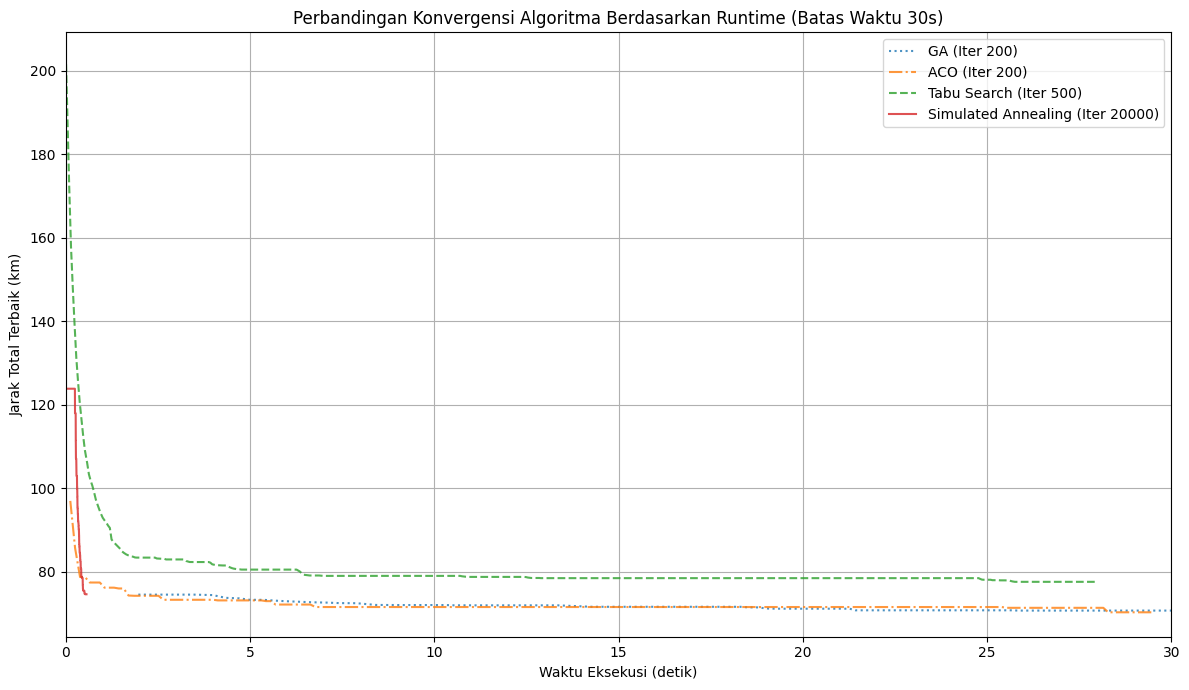

In [ ]:
import matplotlib.pyplot as plt

print("\nMengumpulkan riwayat konvergensi KHUSUS untuk plotting runtime...")

# Ambil data history dan time masing-masing algoritma
algorithms = {
    'GA (Iter 200)': {'history': result_ga['history'], 'time': result_ga['time'], 'style': ':', 'color': 'green'},
    'ACO (Iter 200)': {'history': result_aco['history'], 'time': result_aco['time'], 'style': '-.', 'color': 'blue'},
    'Tabu Search (Iter 500)': {'history': tabu_result['history'], 'time': tabu_result['time'], 'style': '--', 'color': 'orange'},
    'Simulated Annealing (Iter 20000)': {'history': sa_result['history'], 'time': sa_result['time'], 'style': '-', 'color': 'red'}
}

time_limit = 30  # detik

def slice_history_by_time(history, time_history, limit):
    sliced_history = []
    sliced_time = []
    for i, (h, t) in enumerate(zip(history, time_history)):
        if t <= limit:
            sliced_history.append(h)
            sliced_time.append(t)
        else:
            # Interpolasi sederhana jika perlu, atau ambil titik terakhir
            if sliced_time and sliced_time[-1] < limit:
                if i > 0:
                    # Linear interpolation
                    t1, t2 = time_history[i - 1], t
                    h1, h2 = history[i - 1], h
                    interpolated_h = h1 + (h2 - h1) * (limit - t1) / (t2 - t1)
                    sliced_time.append(limit)
                    sliced_history.append(interpolated_h)
            break
    return sliced_history, sliced_time

plt.figure(figsize=(12, 7))

# Loop semua algoritma
for name, data in algorithms.items():
    sliced_history, sliced_time = slice_history_by_time(data['history'], data['time'], time_limit)
    plt.plot(sliced_time, sliced_history, label=name, linestyle=data['style'], alpha=0.8)

# Judul dan label
plt.title(f'Perbandingan Konvergensi Algoritma Berdasarkan Runtime (Batas Waktu {time_limit}s)')
plt.xlabel('Waktu Eksekusi (detik)')
plt.ylabel('Jarak Total Terbaik (km)')
plt.xlim(0, time_limit)

# Y-axis disesuaikan semua data untuk adil
all_histories_full = []
for data in algorithms.values():
    all_histories_full.extend(data['history'])

if all_histories_full:
    plt.ylim(bottom=min(all_histories_full) - 5, top=max(all_histories_full) + 5)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

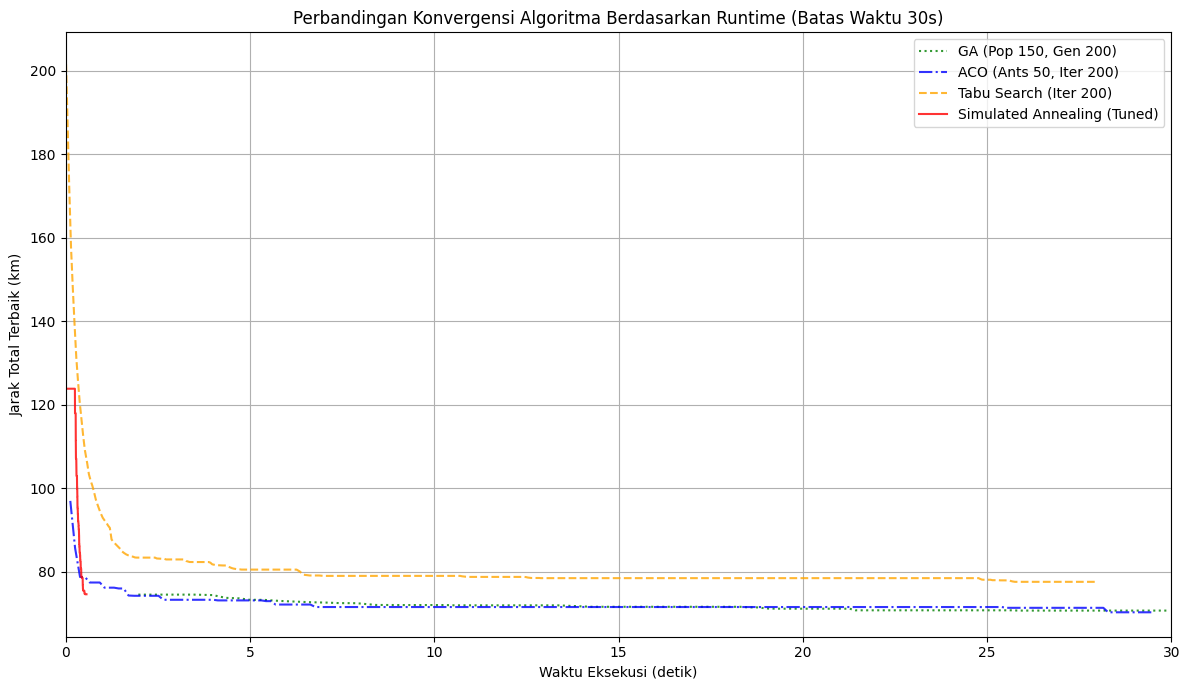

In [ ]:
plt.figure(figsize=(12, 7))

# Batas waktu plot
time_limit = 30 # detik

# Fungsi helper untuk memotong data history berdasarkan batas waktu
def slice_history_by_time(history, time_history, limit):
    sliced_history = []
    sliced_time = []
    for h, t in zip(history, time_history):
        if t <= limit:
            sliced_history.append(h)
            sliced_time.append(t)
        else:
            # Tambahkan titik terakhir sebelum atau tepat di batas waktu jika ada
            if sliced_time and sliced_time[-1] < limit:
                 # Interpolasi jika perlu, atau ambil titik terakhir sebelum limit
                 pass # Untuk kesederhanaan, ambil saja titik terakhir yang <= limit
            break # Hentikan setelah melewati batas waktu
    return sliced_history, sliced_time


# Potong data history berdasarkan batas waktu
ga_history_sliced, ga_time_sliced = slice_history_by_time(ga_history_runtime, ga_time_runtime, time_limit)
aco_history_sliced, aco_time_sliced = slice_history_by_time(aco_history_runtime, aco_time_runtime, time_limit)
tabu_history_sliced, tabu_time_sliced = slice_history_by_time(tabu_history_runtime, tabu_time_runtime, time_limit)
sa_history_sliced, sa_time_sliced = slice_history_by_time(sa_history_runtime, sa_time_runtime, time_limit)


# GA → dotted
plt.plot(
    ga_time_sliced, ga_history_sliced,
    label='GA (Pop 150, Gen 200)',
    linestyle=':',
    color='green',
    alpha=0.8
)

# ACO → dash-dot
plt.plot(
    aco_time_sliced, aco_history_sliced,
    label='ACO (Ants 50, Iter 200)',
    linestyle='-.',
    color='blue',
    alpha=0.8
)

# Tabu → dashed
plt.plot(
    tabu_time_sliced, tabu_history_sliced,
    label='Tabu Search (Iter 200)',
    linestyle='--',
    color='orange',
    alpha=0.8
)

# SA → solid
plt.plot(
    sa_time_sliced, sa_history_sliced,
    label='Simulated Annealing (Tuned)',
    linestyle='-',
    color='red',
    alpha=0.8
)

# Title dan axis label
plt.title(f'Perbandingan Konvergensi Algoritma Berdasarkan Runtime (Batas Waktu {time_limit}s)') # Update judul
plt.xlabel('Waktu Eksekusi (detik)')
plt.ylabel('Jarak Total Terbaik (km)')

# Set batas x-axis secara eksplisit
plt.xlim(0, time_limit)


# Y-limits otomatis disesuaikan berdasarkan SEMUA data (bukan hanya yang terpotong) untuk perbandingan yang adil
all_histories_full = result_ga['history'] + result_aco['history'] + tabu_result['history'] + sa_result['history']
# Pastikan history tidak kosong
if all_histories_full:
    plt.ylim(bottom=min(all_histories_full) - 5, top=max(all_histories_full) + 5)


plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# import math # Diperlukan untuk math.ceil
# import numpy as np # Diperlukan untuk np.zeros

# def create_ortools_data_model(demands_dict, distance_matrix_sparse, vehicle_capacity_single, depot_id_original):
#     """
#     Mempersiapkan data untuk OR-Tools VRP solver, memetakan ID asli (sparse)
#     ke indeks 0-based yang berurutan yang diharapkan OR-Tools.

#     Args:
#         demands_dict (dict): Dictionary {original_id: demand_value}
#         distance_matrix_sparse (np.array): Matriks jarak berdasarkan ID asli.
#         vehicle_capacity_single (int): Kapasitas tunggal per kendaraan.
#         depot_id_original (int): ID depot dalam sistem ID asli.

#     Returns:
#         dict: Data model yang siap untuk OR-Tools, termasuk mapping ID.
#     """
#     # 1. Dapatkan semua ID node unik yang asli (termasuk depot jika ada di demands)
#     # Pastikan depot_id_original memang ada di demands_dict jika tidak, tambahkan dulu (handled di luar)
#     all_original_ids = sorted(list(demands_dict.keys()))

#     # 2. Buat mapping dari ID asli ke indeks 0-based untuk OR-Tools
#     original_id_to_ortools_idx = {id_val: idx for idx, id_val in enumerate(all_original_ids)}
#     ortools_idx_to_original_id = {idx: id_val for id_val, idx in original_id_to_ortools_idx.items()}

#     # 3. Tentukan indeks depot baru dalam sistem 0-based OR-Tools
#     ortools_depot_idx = original_id_to_ortools_idx[depot_id_original]

#     # 4. Buat daftar permintaan yang padat (dense) untuk OR-Tools
#     # Ukuran sesuai jumlah node di OR-Tools
#     ortools_demands = [demands_dict[ortools_idx_to_original_id[i]] for i in range(len(all_original_ids))]

#     # 5. Buat matriks jarak yang padat (dense) untuk OR-Tools
#     num_ortools_nodes = len(all_original_ids)
#     ortools_dist_matrix = np.zeros((num_ortools_nodes, num_ortools_nodes))

#     for i_ortools in range(num_ortools_nodes):
#         for j_ortools in range(num_ortools_nodes):
#             original_i = ortools_idx_to_original_id[i_ortools]
#             original_j = ortools_idx_to_original_id[j_ortools]

#             # Gunakan matriks jarak yang ada (yang mungkin sparse/ID-based)
#             # Pastikan original_i, original_j ada dalam batas matriks jarak_sparse
#             if original_i < distance_matrix_sparse.shape[0] and original_j < distance_matrix_sparse.shape[1]:
#                  ortools_dist_matrix[i_ortools][j_ortools] = distance_matrix_sparse[original_i][original_j]
#             else:
#                  # Seharusnya tidak terjadi jika all_original_ids dikumpulkan dengan benar
#                  # Tapi sebagai fallback, set jarak yang sangat besar
#                  ortools_dist_matrix[i_ortools][j_ortools] = float('inf')

#     # Tentukan jumlah kendaraan yang dibutuhkan oleh OR-Tools
#     # Asumsi minimal 1 kendaraan
#     total_demand = sum(demands_dict[k] for k in demands_dict if k != depot_id_original)
#     min_vehicles = math.ceil(total_demand / vehicle_capacity_single) if total_demand > 0 else 1
#     # Beri sedikit lebih banyak kendaraan dari yang sangat minimum untuk fleksibilitas
#     num_vehicles = max(min_vehicles + 1, 1) # Setidaknya 1 kendaraan

#     return {
#         "distance_matrix": ortools_dist_matrix.tolist(), # OR-Tools prefers list of lists
#         "demands": ortools_demands,
#         "vehicle_capacities": [vehicle_capacity_single] * num_vehicles,
#         "num_vehicles": num_vehicles,
#         "num_nodes": num_ortools_nodes, # Total node dalam sistem OR-Tools
#         "depot_index": ortools_depot_idx,
#         "original_id_to_ortools_idx": original_id_to_ortools_idx, # Mapping untuk konversi balik
#         "ortools_idx_to_original_id": ortools_idx_to_original_id # Mapping untuk konversi balik
#     }

# **OR-Tools**

In [ ]:
# !pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 21.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.31.1 which is incompatible.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", 

In [ ]:
# from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# def run_ortools_vrp_fixed(
#     distance_matrix_processed, demands_processed, coordinates_processed,
#     depot_id, vehicle_capacity, num_vehicles, time_limit_sec=30
# ):
#     # === STEP 1: Buat mapping ID asli <-> index OR-Tools ===
#     original_ids = list(coordinates_processed.keys())
#     ortools_idx_to_original_id = {i: original_ids[i] for i in range(len(original_ids))}
#     original_id_to_ortools_idx = {v: k for k, v in ortools_idx_to_original_id.items()}

#     # === STEP 2: Buat Manager & Model ===
#     manager = pywrapcp.RoutingIndexManager(
#         len(original_ids), num_vehicles, original_id_to_ortools_idx[depot_id]
#     )
#     model = pywrapcp.RoutingModel(manager)

#     # === STEP 3: Distance callback pakai ID asli ===
#     def distance_callback(from_index, to_index):
#         from_node = manager.IndexToNode(from_index)
#         to_node = manager.IndexToNode(to_index)
#         orig_from_id = ortools_idx_to_original_id[from_node]
#         orig_to_id = ortools_idx_to_original_id[to_node]
#         return int(distance_matrix_processed[orig_from_id][orig_to_id])

#     transit_callback_index = model.RegisterTransitCallback(distance_callback)
#     model.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

#     # === STEP 4: Demand callback pakai ID asli ===
#     def demand_callback(from_index):
#         from_node = manager.IndexToNode(from_index)
#         orig_from_id = ortools_idx_to_original_id[from_node]
#         return demands_processed[orig_from_id]

#     demand_callback_index = model.RegisterUnaryTransitCallback(demand_callback)
#     model.AddDimensionWithVehicleCapacity(
#         demand_callback_index, 0, [vehicle_capacity]*num_vehicles, True, 'Capacity'
#     )

#     # === STEP 5: Search Parameters ===
#     search_parameters = pywrapcp.DefaultRoutingSearchParameters()
#     search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
#     search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
#     search_parameters.time_limit.FromSeconds(time_limit_sec)

#     # === STEP 6: Solve ===
#     assignment = model.SolveWithParameters(search_parameters)

#     # === STEP 7: Parse Solution ===
#     if assignment:
#         routes = []
#         total_distance = 0
#         for vehicle_id in range(num_vehicles):
#             index = model.Start(vehicle_id)
#             route = []
#             route_distance = 0
#             while not model.IsEnd(index):
#                 node = manager.IndexToNode(index)
#                 orig_node = ortools_idx_to_original_id[node]
#                 route.append(orig_node)

#                 next_index = assignment.Value(model.NextVar(index))
#                 if not model.IsEnd(next_index):
#                     next_node = manager.IndexToNode(next_index)
#                     orig_next_node = ortools_idx_to_original_id[next_node]
#                     route_distance += distance_matrix_processed[orig_node][orig_next_node]

#                 index = next_index

#             # Add depot at end
#             route.append(depot_id)
#             if len(route) > 2:  # avoid empty routes
#                 routes.append(route)
#                 total_distance += route_distance

#         return {"best_routes": routes, "best_distance": total_distance}

#     else:
#         print("No solution found.")
#         return {"best_routes": [], "best_distance": float('inf')}

In [ ]:
# ortools_result = run_ortools_vrp_fixed(
#     distance_matrix_processed, demands_processed, coordinates_processed,
#     depot_id, vehicle_capacity, len(demands_processed)
# )

In [ ]:
# # Output Formatter untuk OR-Tools (biar seragam kayak ACO/GA/PSO)

# def print_ortools_result(ortools_result, demands_processed, distance_matrix_processed, depot_id, vehicle_capacity):
#     print(f"Best Total Distance: {ortools_result['best_distance']:.2f} km\n")

#     print("Best Routes (OR-Tools):")
#     total_customers_served = 0
#     if ortools_result['best_routes']:
#         for i, route in enumerate(ortools_result['best_routes']):
#             # Hitung cost per rute
#             route_cost = 0
#             for j in range(len(route) - 1):
#                 node_from = route[j]
#                 node_to = route[j+1]
#                 route_cost += distance_matrix_processed[node_from][node_to]

#             # Hitung load per rute
#             customers_in_this_route = [node for node in route if node != depot_id]
#             route_load = sum(demands_processed.get(c, 0) for c in customers_in_this_route)

#             print(f"  Rute {i+1}: {route} (Cost: {route_cost:.2f}, Load: {route_load}/{vehicle_capacity})")

#             total_customers_served += len(customers_in_this_route)
#     else:
#         print("No valid routes found by OR-Tools.")

#     print(f"\nTotal Pelanggan Terlayani: {total_customers_served}")
#     print(f"Jumlah Rute: {len(ortools_result['best_routes'])}")


In [ ]:
# print_ortools_result(
#     ortools_result,
#     demands_processed,
#     distance_matrix_processed,
#     depot_id,
#     vehicle_capacity
# )

Best Total Distance: 62.22 km

Best Routes (OR-Tools):
  Rute 1: [0, 48, 43, 12, 1, 49, 29, 40, 26, 6, 0] (Cost: 10.57, Load: 80/80)
  Rute 2: [0, 8, 2, 30, 35, 38, 10, 22, 34, 0] (Cost: 10.90, Load: 73/80)
  Rute 3: [0, 31, 47, 28, 5, 9, 14, 21, 23, 41, 0] (Cost: 16.57, Load: 78/80)
  Rute 4: [0, 32, 36, 33, 20, 24, 19, 0] (Cost: 6.18, Load: 56/80)
  Rute 5: [0, 15, 25, 37, 16, 7, 46, 50, 39, 18, 0] (Cost: 18.60, Load: 80/80)
  Rute 6: [0, 42, 51, 17, 44, 13, 11, 3, 4, 27, 0] (Cost: 13.25, Load: 80/80)

Total Pelanggan Terlayani: 50
Jumlah Rute: 6


In [ ]:
import pandas as pd

# Buat tabel perbandingan performa algoritma
comparison_data = {
    "Algorithm": ["Genetic Algorithm (GA)", "Ant Colony Optimization (ACO)", "Tabu Search", "Simulated Annealing (SA)"],
    "Best Distance": [
        round(ga_stats["min"], 2),
        round(aco_stats["min"], 2),
        round(tabu_stats["min"], 2),
        round(sa_stats["min"], 2)
    ],
    "Avg Distance": [
        round(ga_stats["mean"], 2),
        round(aco_stats["mean"], 2),
        round(tabu_stats["mean"], 2),
        round(sa_stats["mean"], 2)
    ],
    "Std. Dev": [
        round(ga_stats["std"], 2),
        round(aco_stats["std"], 2),
        round(tabu_stats["std"], 2),
        round(sa_stats["std"], 2)
    ],
    "CPU Time (s)": [
        round(ga_stats["avg_runtime"], 2),
        round(aco_stats["avg_runtime"], 2),
        round(tabu_stats["avg_runtime"], 2),
        round(sa_stats["avg_runtime"], 2)
    ]
}

# Konversi ke DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Cetak tabel dalam format markdown agar rapi di console / Jupyter
print("\n=== Tabel Perbandingan Algoritma VRP ===")
print(comparison_df.to_markdown(index=False))

# Simpan ke file CSV (opsional)
comparison_df.to_csv("tabel_perbandingan_algoritma.csv", index=False)



=== Tabel Perbandingan Algoritma VRP ===
| Algorithm                     |   Best Distance |   Avg Distance |   Std. Dev |   CPU Time (s) |
|:------------------------------|----------------:|---------------:|-----------:|---------------:|
| Genetic Algorithm (GA)        |           68.68 |          69.61 |       0.73 |          32.03 |
| Ant Colony Optimization (ACO) |           69.88 |          70.69 |       0.4  |          27.14 |
| Tabu Search                   |           70.44 |          75.69 |       3.55 |          10.54 |
| Simulated Annealing (SA)      |           71.38 |          74.06 |       2.07 |           0.61 |
